In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import scipy.stats as stats
import warnings
from sqlalchemy import create_engine

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

__Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.__

In [3]:
df.head(30)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,...,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,...,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,...,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,...,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


So, it looks like the data is arranged by country, then year. Good to know for potential interpolation!

__Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them__

In [4]:
#there's some whitespace around our column names
df.rename(str.strip, axis='columns', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
BMI                                2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
HIV/AIDS                           2938 non-null

In [5]:
df.nunique()

Country                             193
Year                                 16
Status                                2
Life expectancy                     362
Adult Mortality                     425
infant deaths                       209
Alcohol                            1076
percentage expenditure             2328
Hepatitis B                          87
Measles                             958
BMI                                 608
under-five deaths                   252
Polio                                73
Total expenditure                   818
Diphtheria                           81
HIV/AIDS                            200
GDP                                2490
Population                         2278
thinness  1-19 years                200
thinness 5-9 years                  207
Income composition of resources     625
Schooling                           173
dtype: int64

In [6]:
#see if there are strange entries in the string columns
string_columns = []
for column in df.columns:
    if (type(df[column][0]) == str):
        string_columns.append(column)
        
for column in string_columns:
    print('Column: {}'.format(column))
    print(df[column].unique())
    print('')

Column: Country
['Afghanistan' 'Albania' 'Algeria' "Côte d'Ivoire" 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia (Plurinational State of)'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Slovakia'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland'
 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras'
 'Hungary' 'Iceland' 'India' 'Indonesia' '

These seem to have no missing values worth discovering. Let's look at our other values for N/A's

In [7]:
df.isnull().sum() / df.isnull().count() * 100

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
thinness  1-19 years                1.157250
thinness 5-9 years                  1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

Look at Oman's Population.

In [8]:
df.loc[df['Country'] == 'Oman']

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1927,Oman,2015,Developing,76.6,99.0,1,NaN,0.000000,99.0,0,...,99.0,NaN,99.0,0.1,16627.36433,NaN,7.1,6.9,0.795,13.7
1928,Oman,2014,Developing,76.4,11.0,1,0.40,166.191373,99.0,0,...,99.0,3.55,99.0,0.1,2458.45226,NaN,7.1,6.9,0.796,13.7
1929,Oman,2013,Developing,76.2,12.0,1,0.46,1154.893473,98.0,0,...,99.0,2.76,98.0,0.1,21268.75640,NaN,7.0,6.8,0.796,13.7
1930,Oman,2012,Developing,76.0,14.0,1,0.51,1055.835493,98.0,13,...,99.0,2.52,98.0,0.1,22134.91600,NaN,7.0,6.8,0.797,13.7
1931,Oman,2011,Developing,75.8,15.0,1,0.54,158.277080,99.0,5,...,99.0,2.49,99.0,0.1,2986.36000,NaN,6.9,6.8,0.797,13.6
1932,Oman,2010,Developing,75.6,16.0,1,0.56,129.226075,99.0,3,...,99.0,2.74,99.0,0.1,1928.74739,NaN,6.9,6.8,0.797,13.5
1933,Oman,2009,Developing,75.4,18.0,1,0.56,1040.629462,98.0,19,...,96.0,2.83,98.0,0.1,16784.34616,NaN,6.9,6.8,0.782,12.4
1934,Oman,2008,Developing,75.2,19.0,1,0.57,123.096630,99.0,18,...,97.0,2.10,99.0,0.1,2275.35360,NaN,6.9,6.8,0.765,11.9
1935,Oman,2007,Developing,74.9,113.0,1,0.57,88.450380,99.0,24,...,97.0,2.43,99.0,0.1,1585.13226,NaN,7.0,6.8,0.753,11.5
1936,Oman,2006,Developing,74.7,115.0,1,0.58,78.511410,99.0,13,...,98.0,2.31,98.0,0.1,1448.55000,NaN,7.0,6.8,0.748,11.6


Look at Norway's Hepatitis B

In [9]:
df.loc[df.Country == 'Norway']

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1911,Norway,2015,Developed,81.8,59.0,0,5.97,0.000000,NaN,14,...,95.0,NaN,95.0,0.1,7455.24654,518867.0,0.8,0.7,0.948,17.7
1912,Norway,2014,Developed,81.6,61.0,0,6.06,177.638288,NaN,3,...,93.0,9.72,93.0,0.1,975.49856,5137232.0,0.8,0.7,0.945,17.7
1913,Norway,2013,Developed,81.5,62.0,0,6.21,234.782883,NaN,8,...,94.0,9.39,94.0,0.1,1291.43500,579623.0,0.8,0.7,0.942,17.5
1914,Norway,2012,Developed,81.3,61.0,0,6.21,2094.190960,NaN,4,...,95.0,9.16,95.0,0.1,11563.72700,518573.0,0.7,0.7,0.941,17.6
1915,Norway,2011,Developed,81.1,67.0,0,6.53,277.355052,NaN,39,...,94.0,9.14,94.0,0.1,1574.98610,495388.0,0.7,0.7,0.939,17.6
1916,Norway,2010,Developed,81.0,66.0,0,6.59,15268.064450,NaN,3,...,93.0,9.26,93.0,0.1,87646.75346,4889252.0,0.7,0.7,0.936,17.4
1917,Norway,2009,Developed,89.0,67.0,0,6.68,142.374943,NaN,2,...,94.0,9.49,94.0,0.1,817.77681,4828726.0,0.7,0.7,0.936,17.4
1918,Norway,2008,Developed,86.0,67.0,0,6.75,1707.130633,NaN,4,...,94.0,8.40,94.0,0.1,9688.59610,4768212.0,0.7,0.7,0.936,17.6
1919,Norway,2007,Developed,85.0,67.0,0,6.60,14829.412150,NaN,0,...,93.0,8.58,93.0,0.1,85128.65759,479153.0,0.7,0.7,0.934,17.6
1920,Norway,2006,Developed,84.0,7.0,0,6.47,12829.254080,NaN,0,...,94.0,8.43,94.0,0.1,74114.69715,466677.0,0.8,0.7,0.931,17.5


And Gambia's GDP

In [10]:
df.loc[df.Country == 'Gambia']

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
963,Gambia,2015,Developing,61.1,262.0,3,NaN,0.0,97.0,71,...,96.0,NaN,97.0,1.7,NaN,NaN,7.3,7.2,0.450,8.9
964,Gambia,2014,Developing,68.0,266.0,3,0.01,0.0,96.0,1,...,97.0,7.34,96.0,1.7,NaN,NaN,7.5,7.3,0.449,8.9
965,Gambia,2013,Developing,66.0,266.0,3,0.01,0.0,97.0,0,...,96.0,6.49,97.0,1.6,NaN,NaN,7.6,7.5,0.445,8.9
966,Gambia,2012,Developing,62.0,269.0,3,0.01,0.0,98.0,0,...,98.0,6.12,98.0,1.4,NaN,NaN,7.8,7.7,0.440,8.8
967,Gambia,2011,Developing,59.8,277.0,3,3.41,0.0,96.0,0,...,95.0,6.24,96.0,1.8,NaN,NaN,8.0,7.9,0.441,8.7
968,Gambia,2010,Developing,59.3,284.0,3,3.48,0.0,97.0,2,...,97.0,5.75,97.0,2.1,NaN,NaN,8.2,8.1,0.439,8.8
969,Gambia,2009,Developing,59.0,286.0,3,2.99,0.0,97.0,0,...,97.0,5.85,98.0,2.7,NaN,NaN,8.4,8.3,0.434,8.9
970,Gambia,2008,Developing,58.7,287.0,3,2.79,0.0,98.0,0,...,96.0,5.95,96.0,3.0,NaN,NaN,8.6,8.5,0.426,8.6
971,Gambia,2007,Developing,58.5,288.0,3,2.64,0.0,97.0,0,...,94.0,5.76,95.0,3.1,NaN,NaN,8.8,8.7,0.420,8.4
972,Gambia,2006,Developing,58.2,288.0,3,2.93,0.0,95.0,0,...,94.0,5.52,95.0,3.0,NaN,NaN,9.0,8.9,0.415,8.1


So, we should probably drop those three columns as some countries don't have any data at all and it doesn't make sense to fill them in with a measure of central tendency or interpolation.

In [11]:
df = df.drop(columns=['Hepatitis B', 'GDP', 'Population'])

Great, now let's fill na's for the rest.

In [12]:
#create some columns for interpolation
columns = df.columns.tolist()
columns.remove('Country')
columns.remove('Year')
columns.remove('Status')

for column in columns:
    df[column] = df[column].interpolate()

In [13]:
df.isnull().sum() / df.isnull().count() * 100

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
thinness  1-19 years               0.0
thinness 5-9 years                 0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

Ok! Let's see if we can find some outliers now...

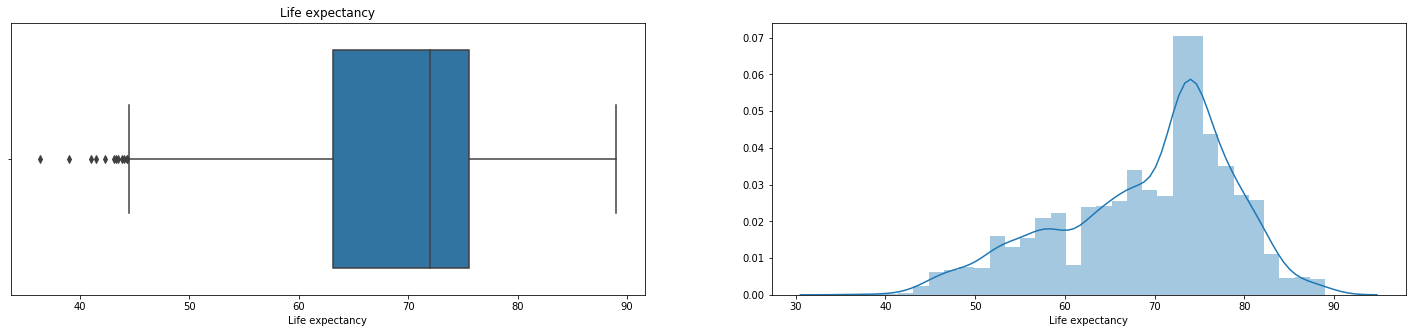

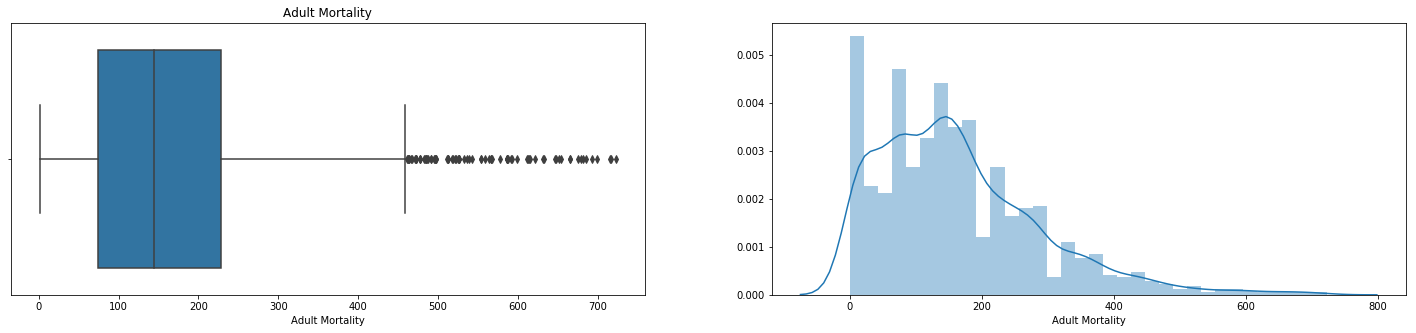

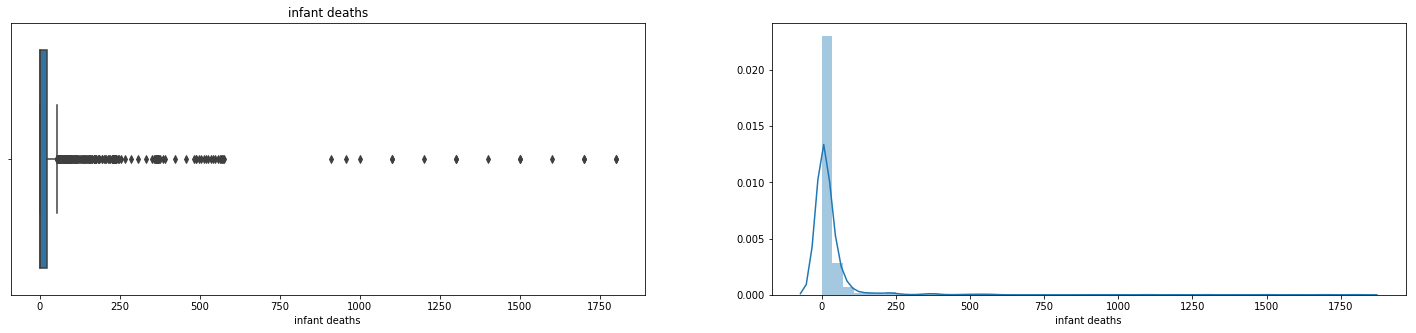

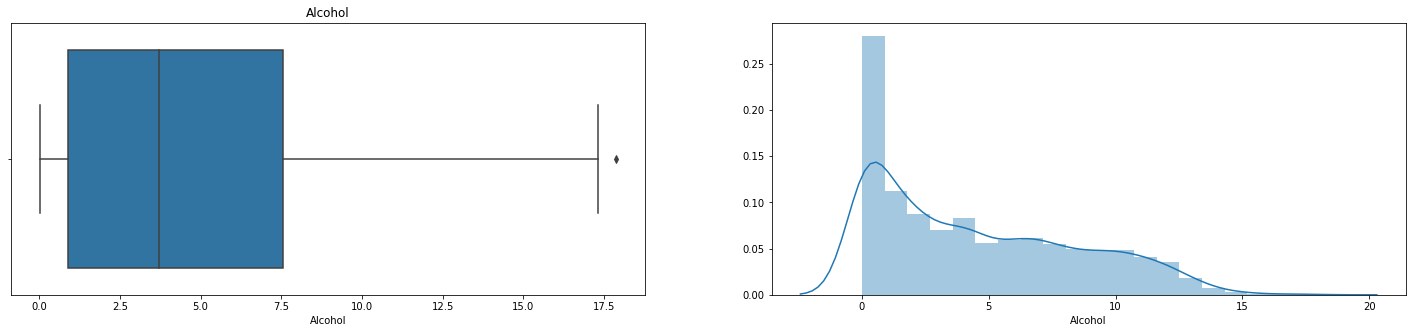

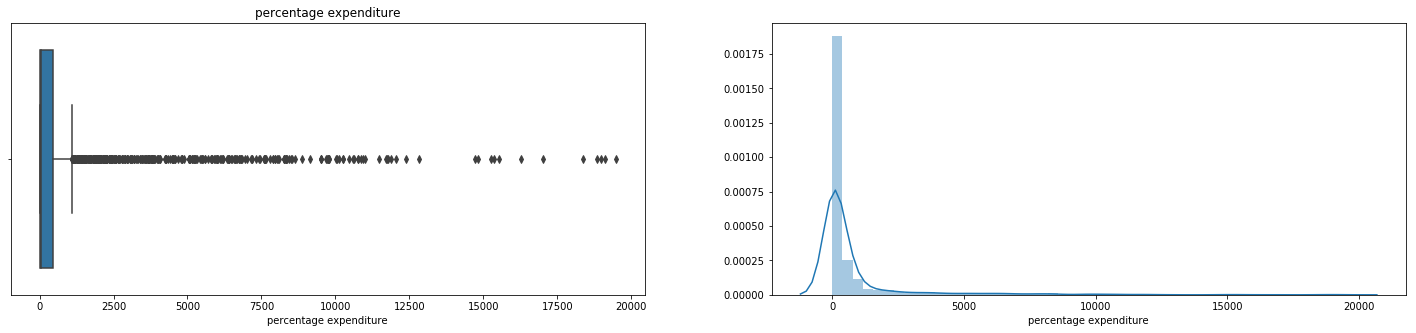

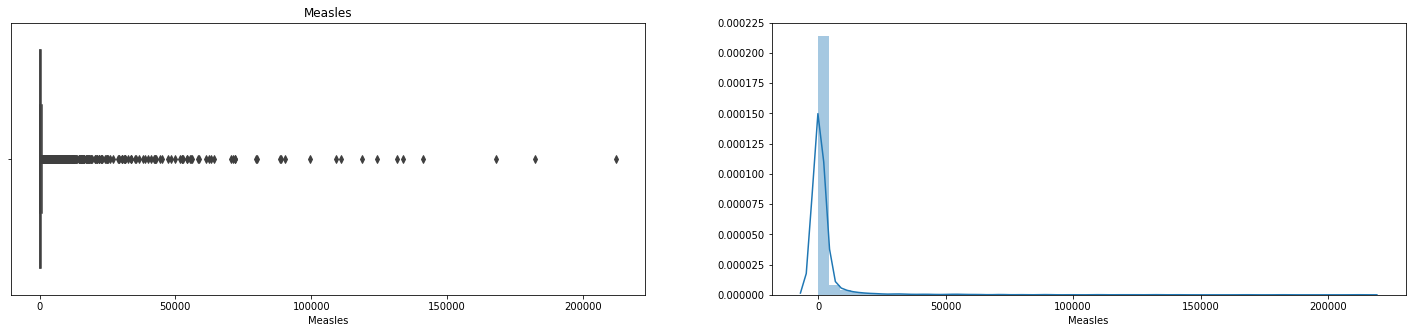

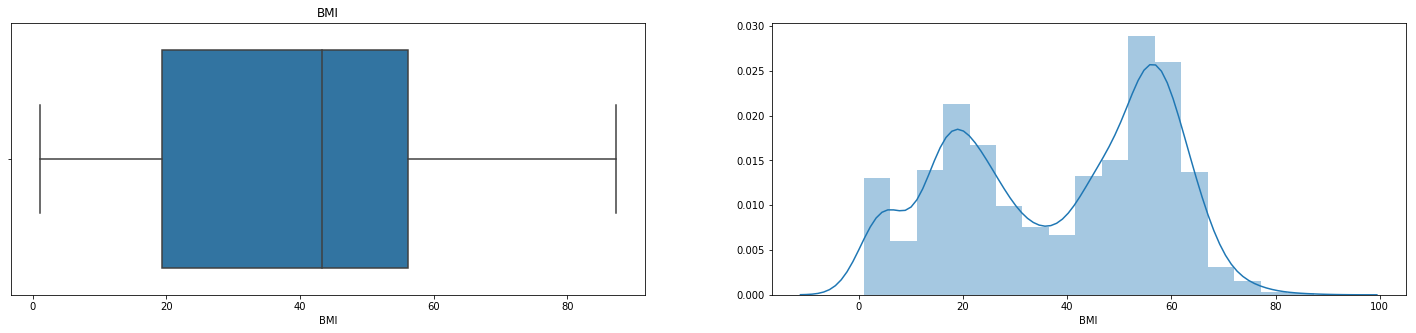

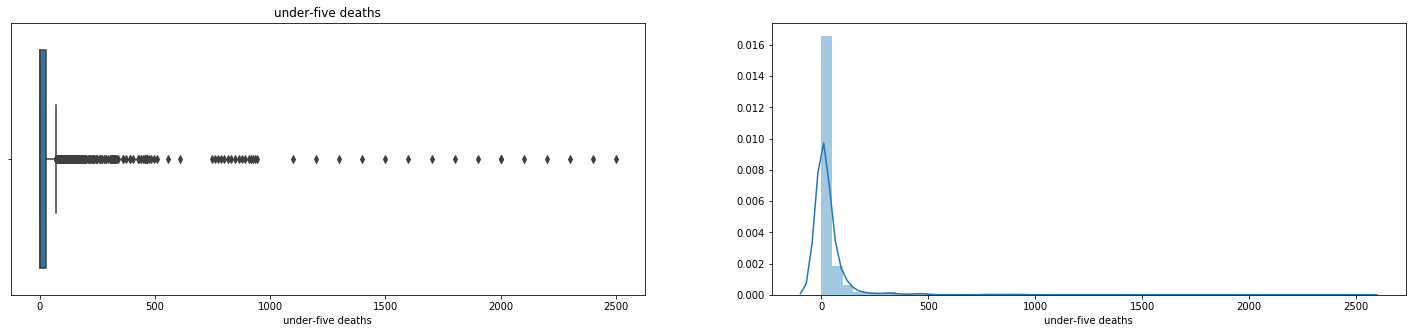

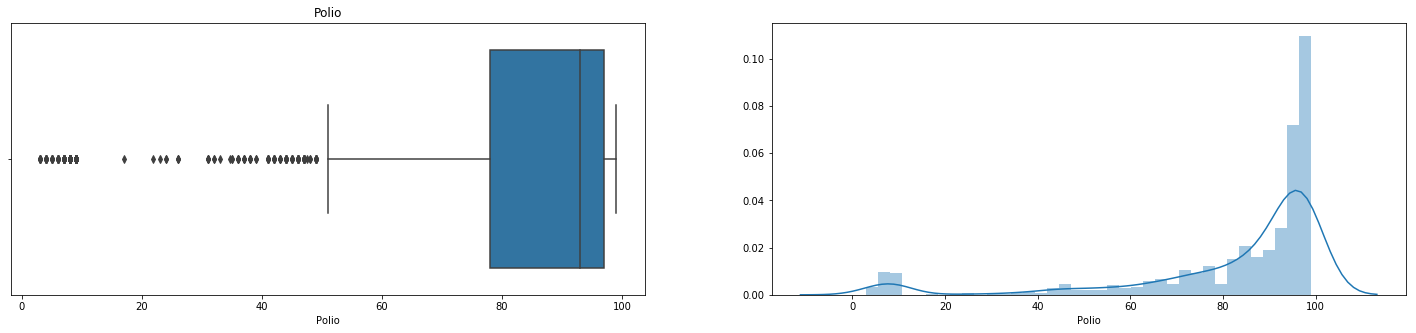

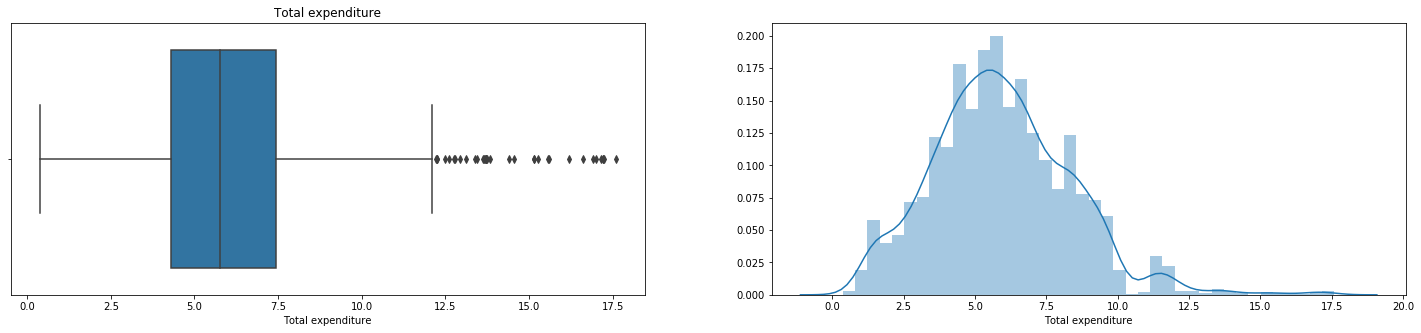

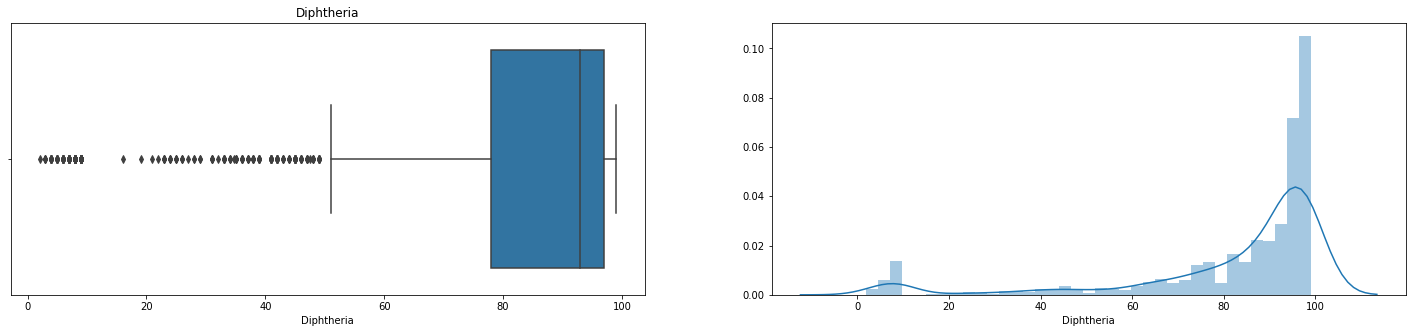

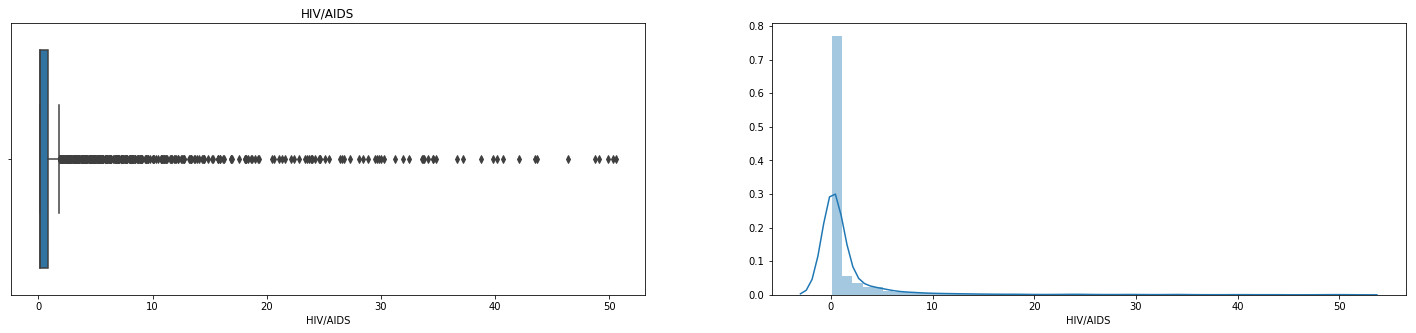

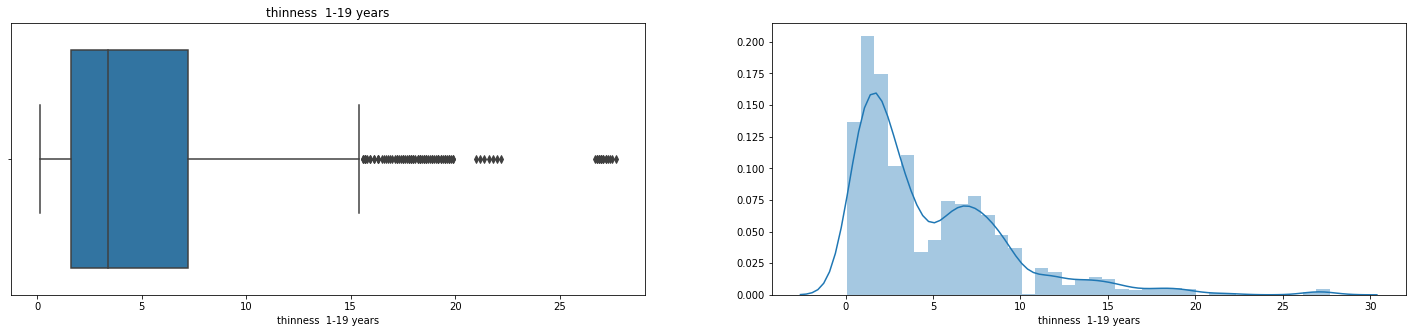

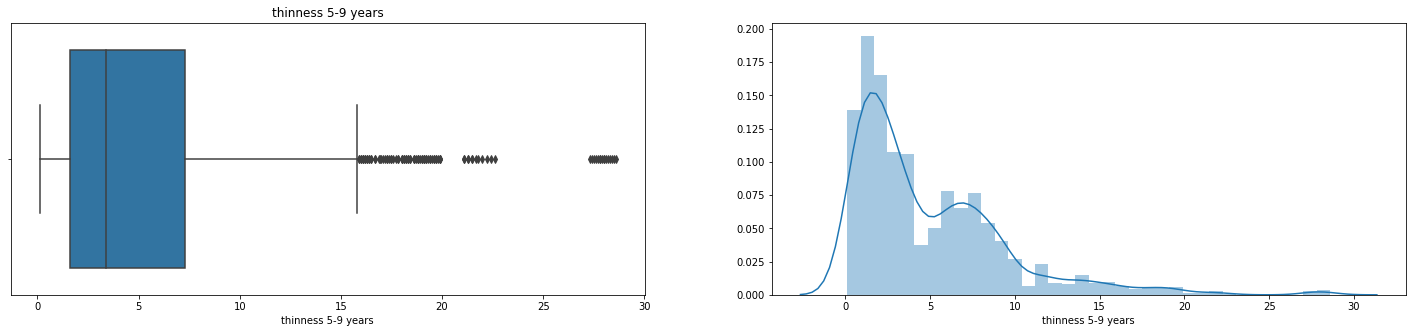

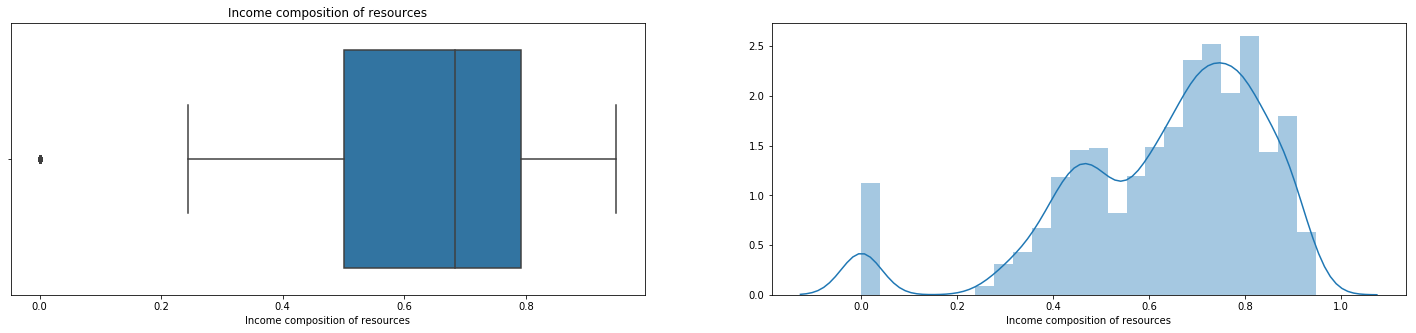

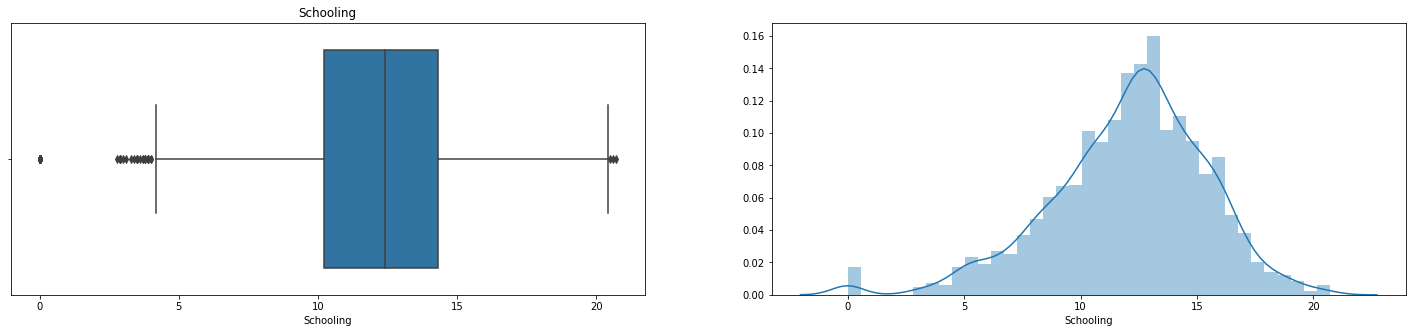

In [14]:
for column in columns:
    plt.figure(figsize=(25, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(df[column])
    plt.title('{}'.format(column))
    
    plt.subplot(1, 2, 2)
    sns.distplot(df[column])
    plt.title(''.format(column))
    
    plt.show()

Almost none of our data seems to be normally distributed, so detecting outliers becomes problematic. I wonder how much the 'status' is affecting the extreme variances within features. Let's find out!

In [15]:
developing = df.loc[df.Status == 'Developing']
developed = developed = df.loc[df.Status == 'Developed']

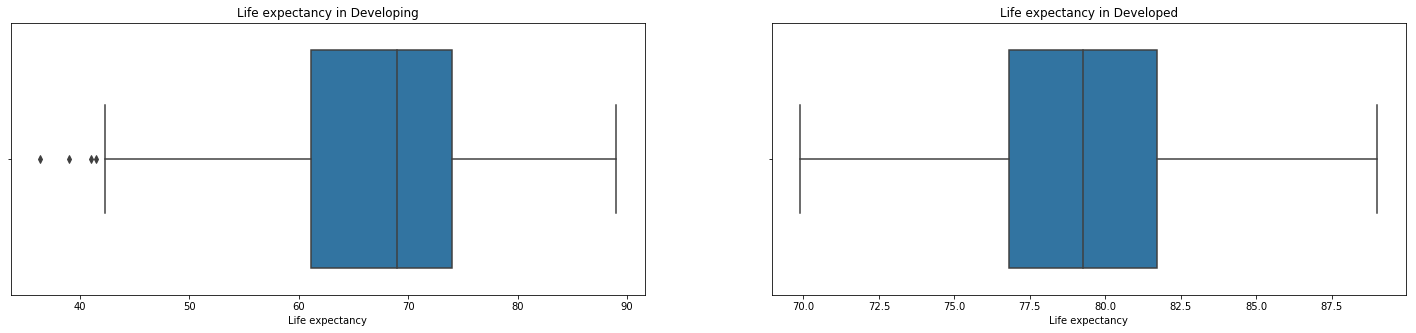

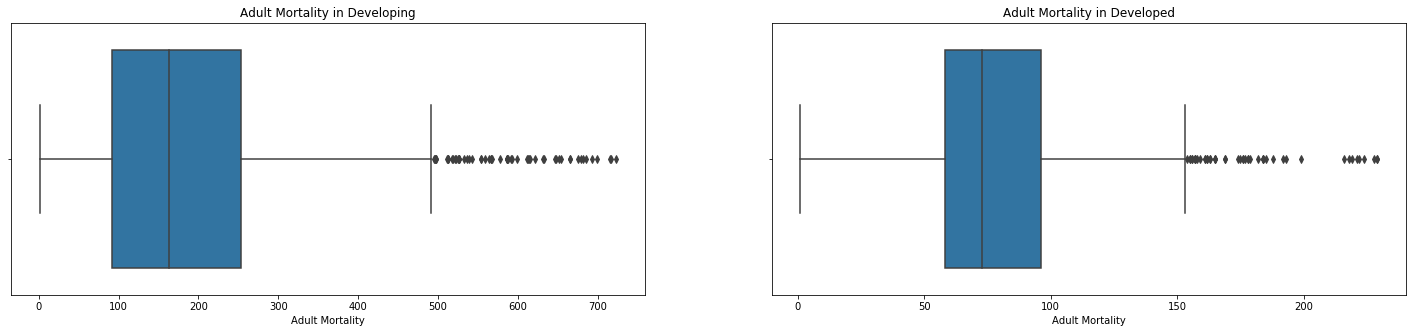

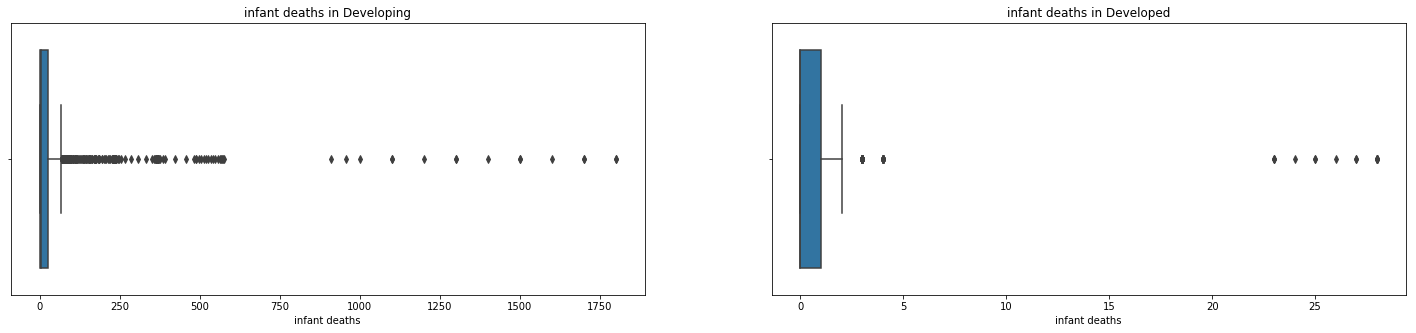

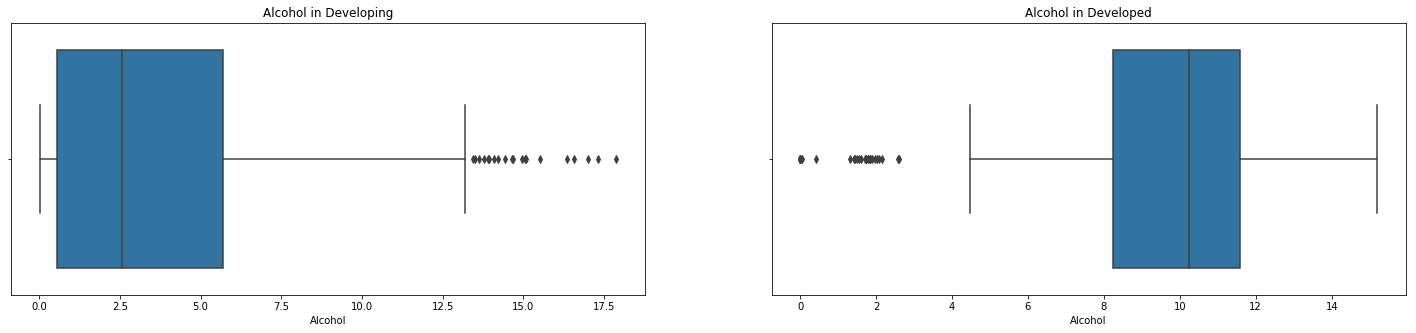

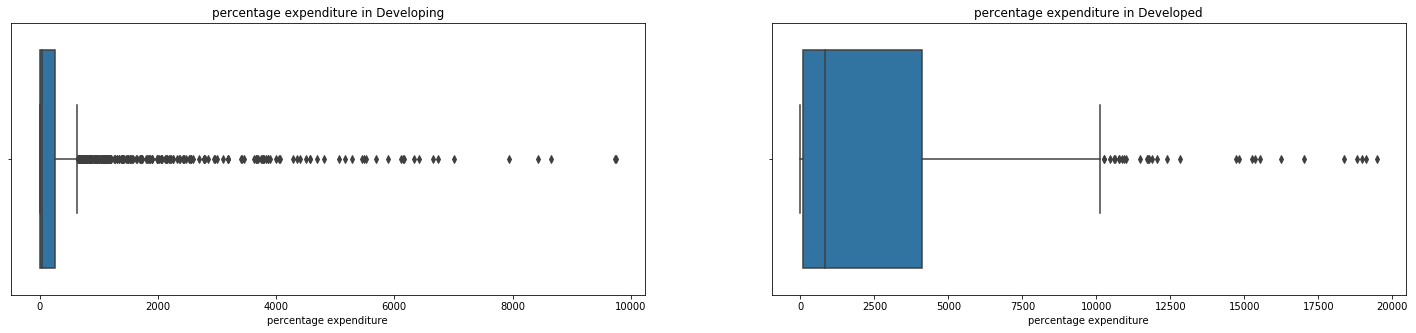

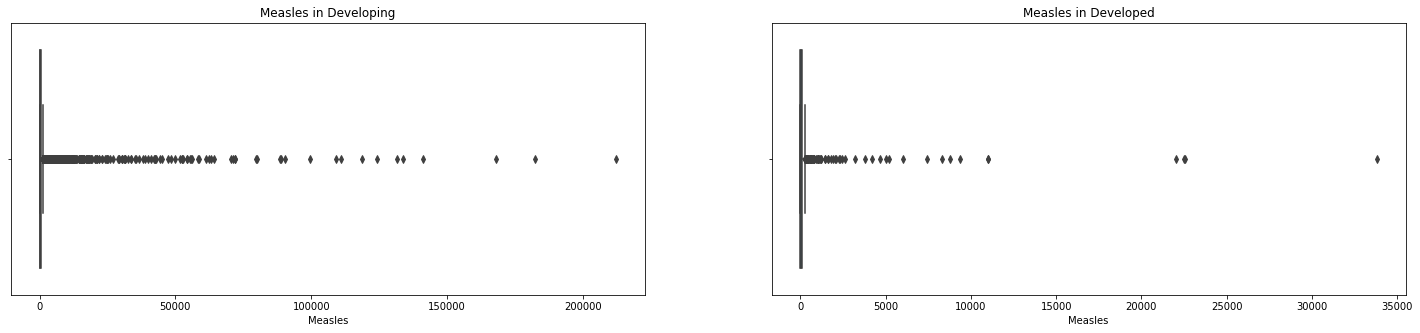

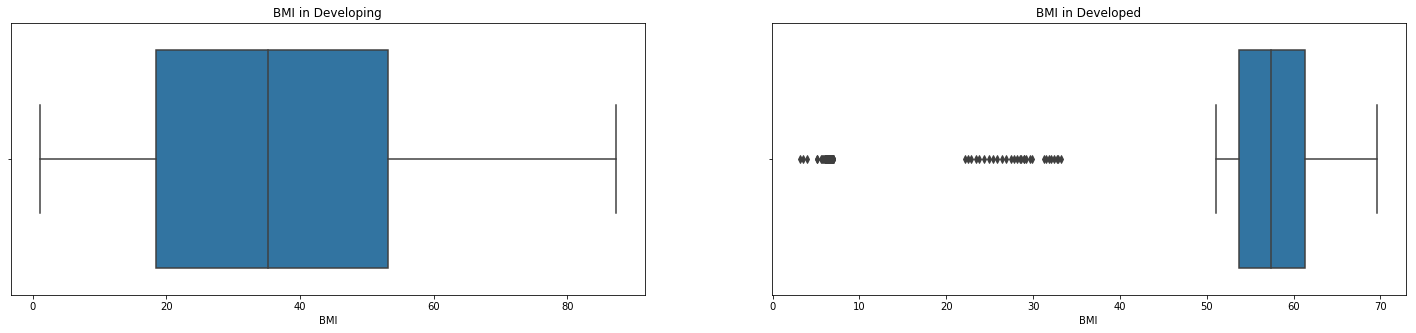

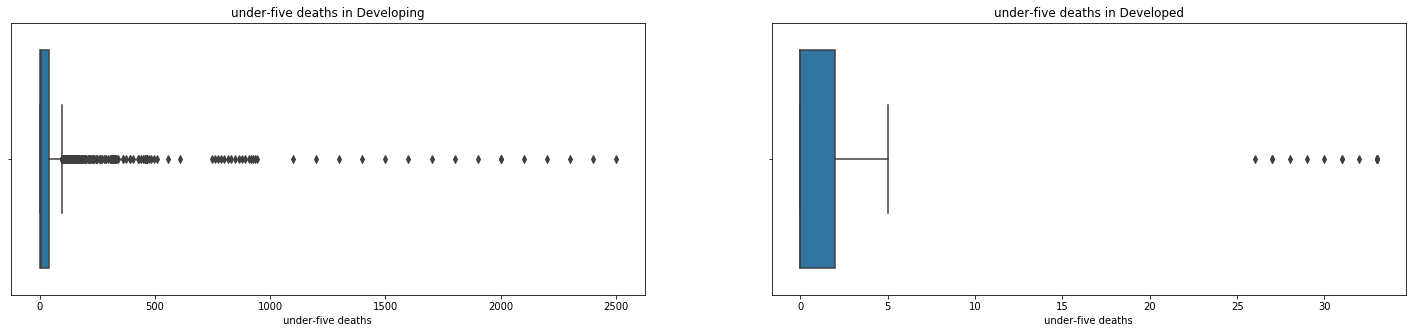

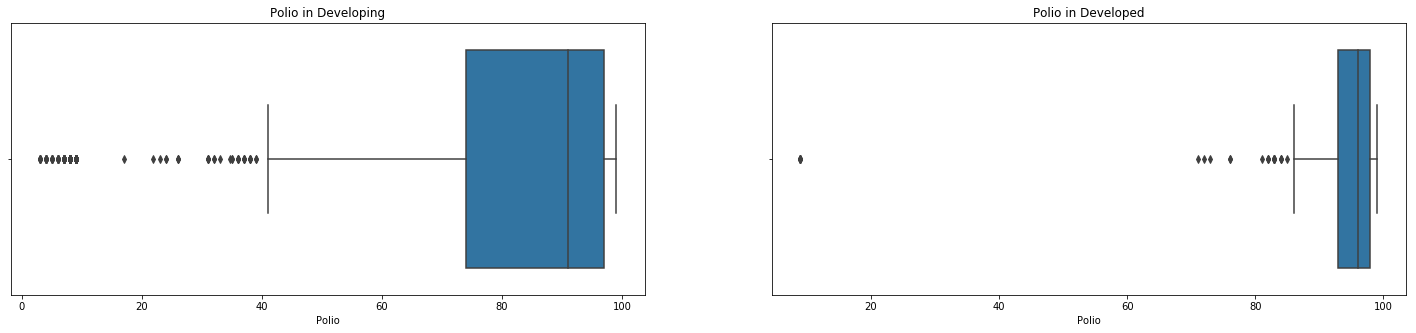

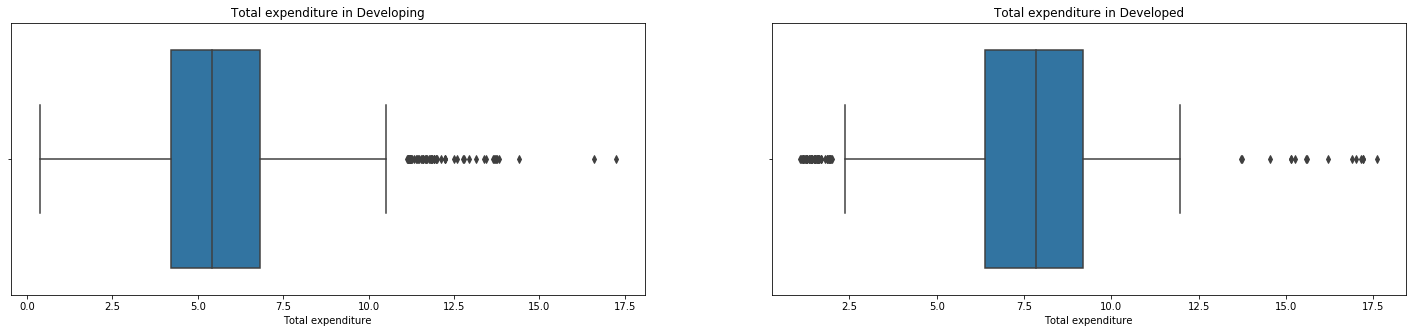

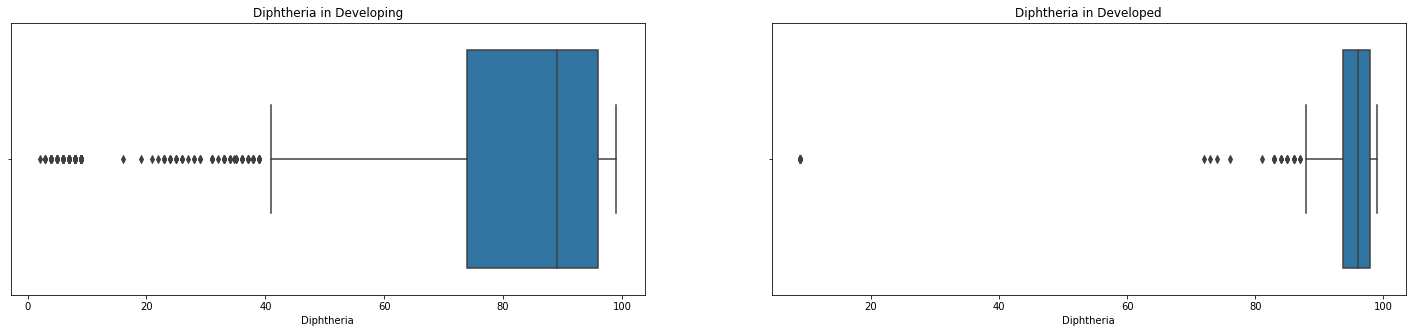

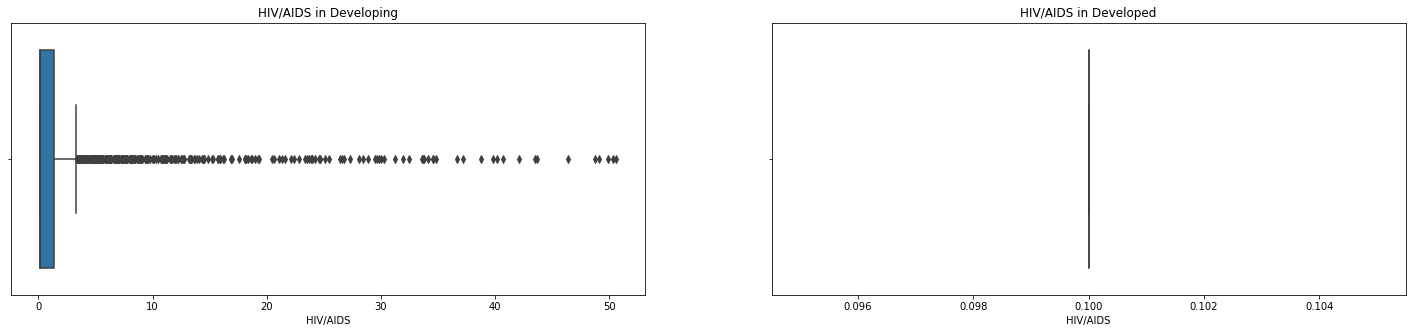

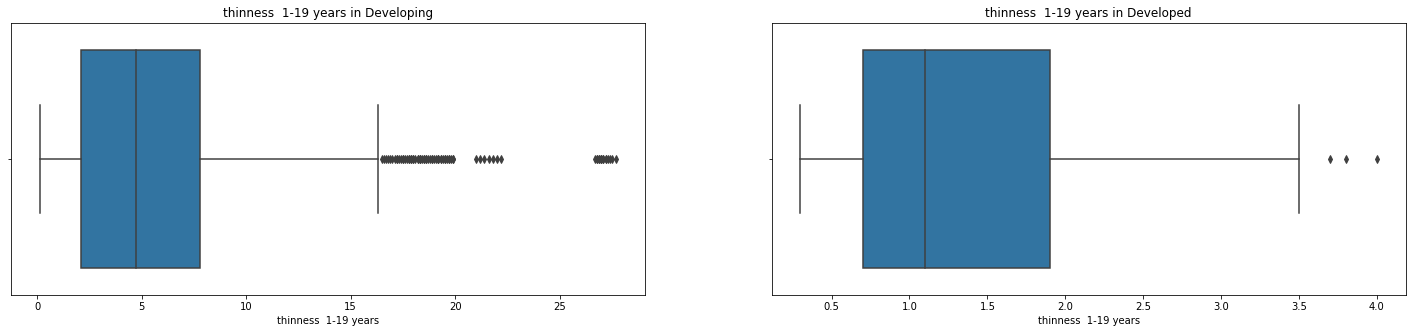

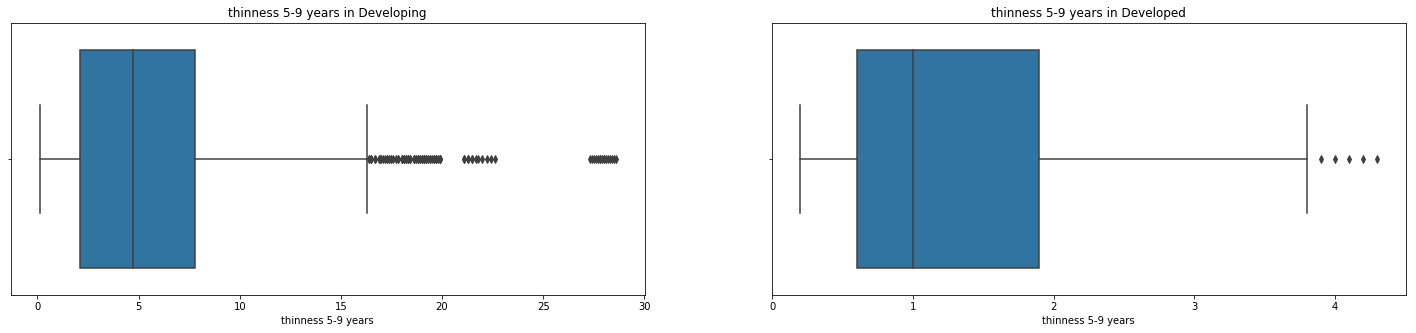

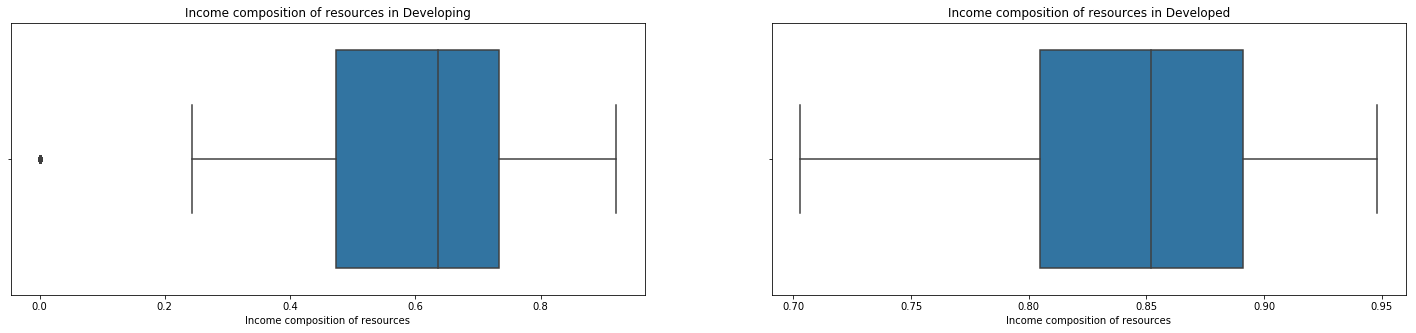

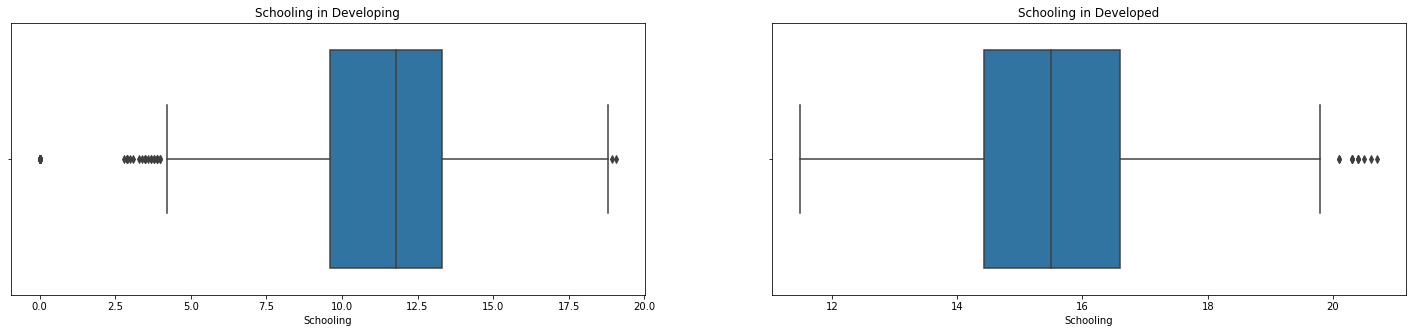

In [16]:
for column in columns:
    plt.figure(figsize=(25, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(column, data=developing)
    plt.title('{} in Developing'.format(column))

    plt.subplot(1, 2, 2)
    sns.boxplot(column, data=developed)
    plt.title('{} in Developed'.format(column))
    plt.show()

So, certain features' (like HIV/AIDS, thinness, diphtheria, BMI) high variance can be explained by the status of the country. This seems a good enough reason to not worry about dealing with outliers. In future iterations, we might come back and transform some of the features infant deaths to make the data easier to manage.

__Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.__


The correlation coefficient between Life Expectancy and Life Expectancy is 1.0


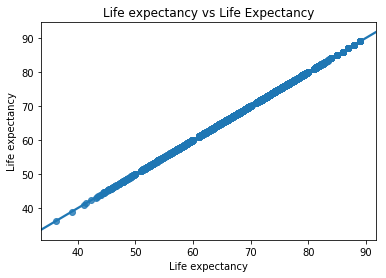

The correlation coefficient between Adult Mortality and Life Expectancy is -0.6957302834909396


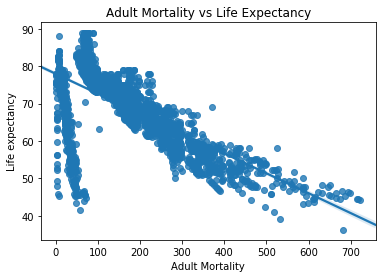

The correlation coefficient between Infant Deaths and Life Expectancy is -0.19619746554529316


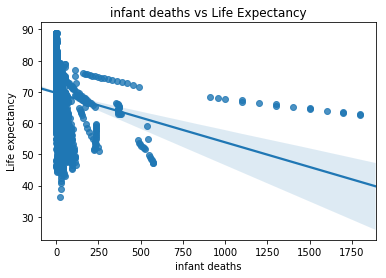

The correlation coefficient between Alcohol and Life Expectancy is 0.40006808360639456


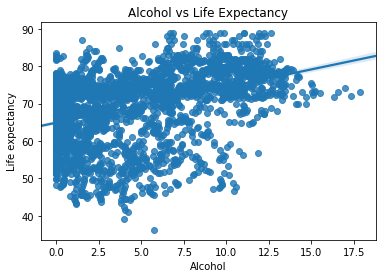

The correlation coefficient between Percentage Expenditure and Life Expectancy is 0.38206885112050176


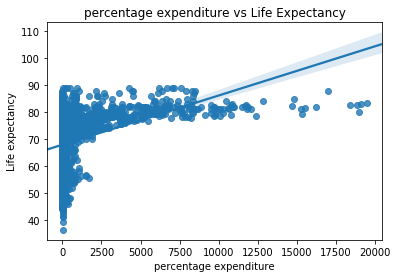

The correlation coefficient between Measles and Life Expectancy is -0.15729793807561737


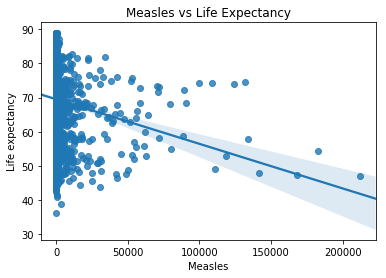

The correlation coefficient between Bmi and Life Expectancy is 0.556433178433153


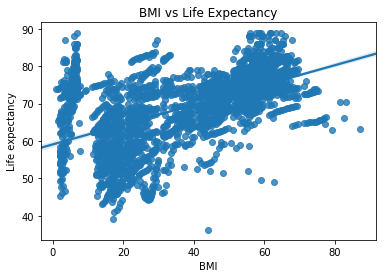

The correlation coefficient between Under-Five Deaths and Life Expectancy is -0.22215149275209978


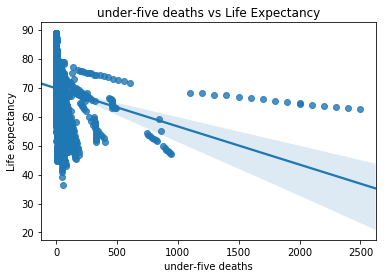

The correlation coefficient between Polio and Life Expectancy is 0.45986461720586697


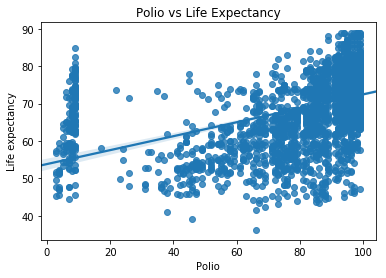

The correlation coefficient between Total Expenditure and Life Expectancy is 0.21084300448275425


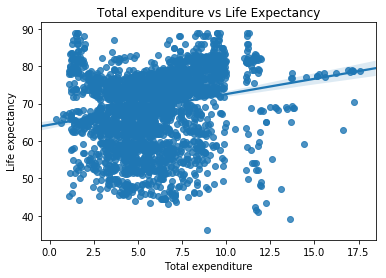

The correlation coefficient between Diphtheria and Life Expectancy is 0.4740844296049732


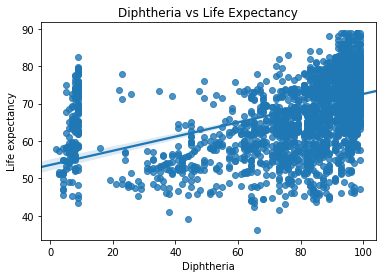

The correlation coefficient between Hiv/Aids and Life Expectancy is -0.5559287057539717


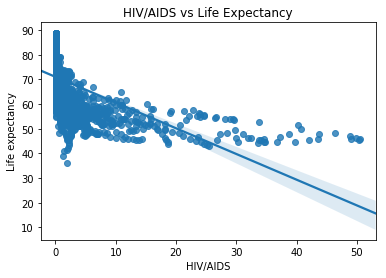

The correlation coefficient between Thinness  1-19 Years and Life Expectancy is -0.476808562984325


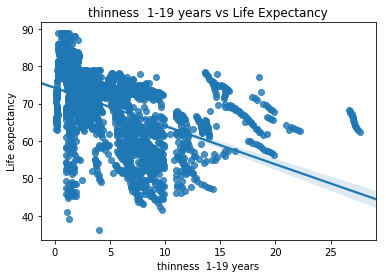

The correlation coefficient between Thinness 5-9 Years and Life Expectancy is -0.47248473590246587


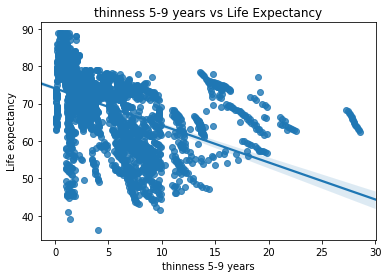

The correlation coefficient between Income Composition Of Resources and Life Expectancy is 0.6900712847842034


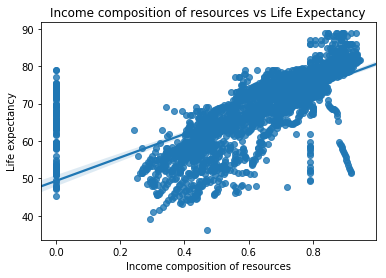

The correlation coefficient between Schooling and Life Expectancy is 0.7034093483533709


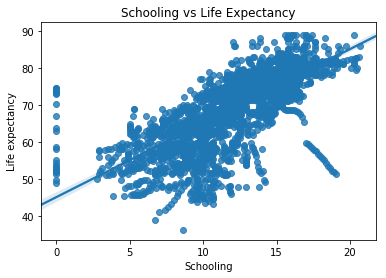

In [16]:
#establish our target variable
target = df['Life expectancy']

#create negative and positive correlations
negatives = ['Life expectancy']
positives = []

for column in columns:
    corr, p_value = stats.pearsonr(target, df[column])
    #add our negative and positive correlations to their respective lists
    if (corr > 0):
        positives.append(column)
    else:
        negatives.append(column)
    
    #view our results
    print('The correlation coefficient between {} and Life Expectancy is {}'.format(column.title(), corr))
    sns.regplot(column, target, data=df)
    plt.title('{} vs Life Expectancy'.format(column))
    plt.show()

Take a look at under-five deaths. It almost seems there's another regression within this visual that is slightly above ours. It could be caused by one, or several, countries with similar values that are changing over time. Let's find out by using some averages!

The correlation coefficient between Life expectancy and life expectancy is 1.0


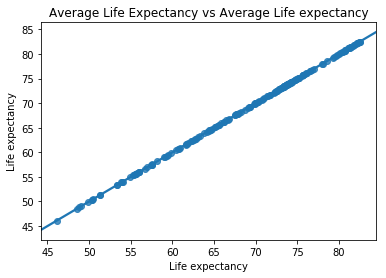

The correlation coefficient between Adult Mortality and life expectancy is -0.8734293444197329


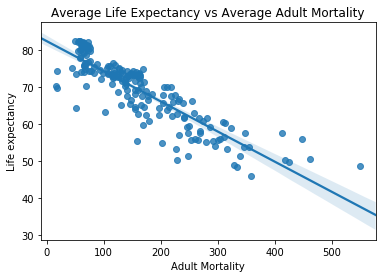

The correlation coefficient between infant deaths and life expectancy is -0.19407961008710733


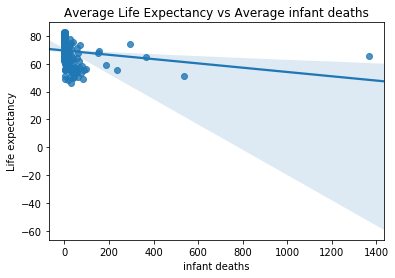

The correlation coefficient between Alcohol and life expectancy is 0.4598777261430643


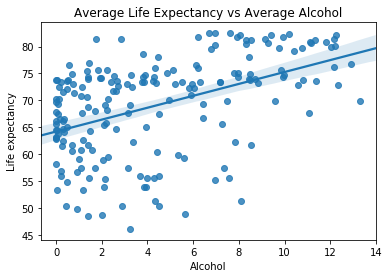

The correlation coefficient between percentage expenditure and life expectancy is 0.5272964553881574


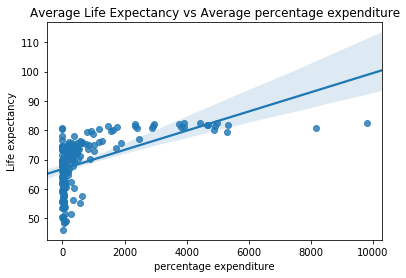

The correlation coefficient between Measles and life expectancy is -0.1944873817062016


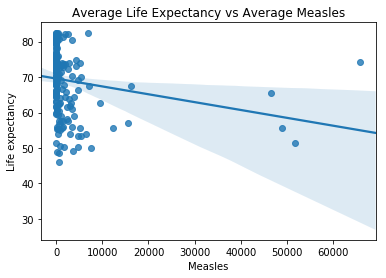

The correlation coefficient between BMI and life expectancy is 0.611276295804708


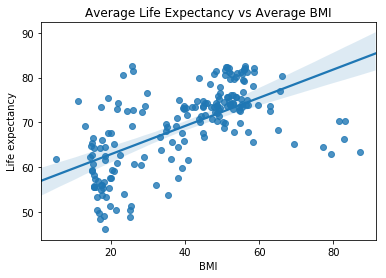

The correlation coefficient between under-five deaths and life expectancy is -0.2196466528374441


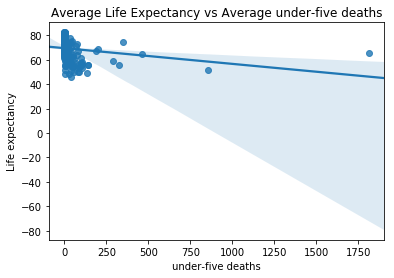

The correlation coefficient between Polio and life expectancy is 0.6257620461760999


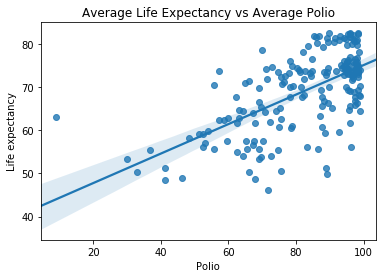

The correlation coefficient between Total expenditure and life expectancy is 0.22305848618716337


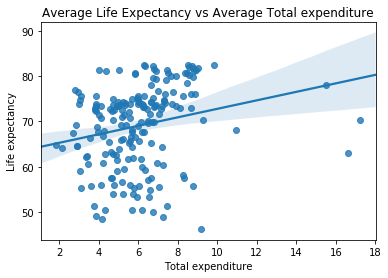

The correlation coefficient between Diphtheria and life expectancy is 0.6221839378500285


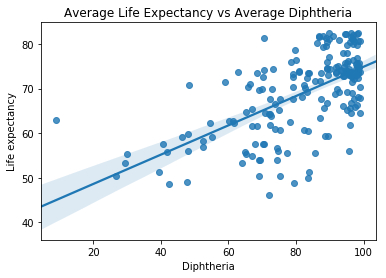

The correlation coefficient between HIV/AIDS and life expectancy is -0.5756396427364631


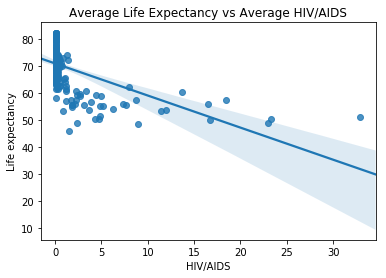

The correlation coefficient between thinness  1-19 years and life expectancy is -0.49938330486754823


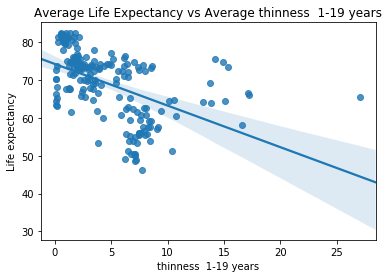

The correlation coefficient between thinness 5-9 years and life expectancy is -0.493666153316984


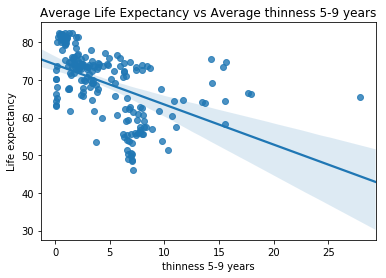

The correlation coefficient between Income composition of resources and life expectancy is 0.7623970932369029


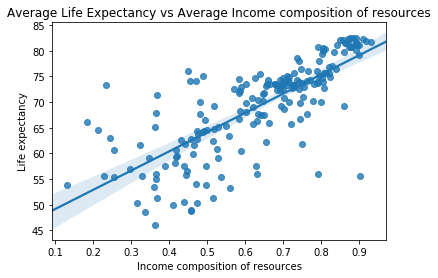

The correlation coefficient between Schooling and life expectancy is 0.6940663672688138


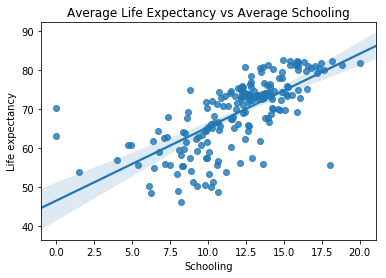

In [27]:
life_average = df.groupby('Country')['Life expectancy'].mean()

for column in columns:
    col_avg = df.groupby('Country')[column].mean()
    
    corr, p_value = stats.pearsonr(col_avg, life_average)
    print('The correlation coefficient between {} and life expectancy is {}'.format(column, corr))
    sns.regplot(col_avg, life_average)
    plt.title('Average Life Expectancy vs Average {}'.format(column))
    plt.show()

These don't look too different. Let's keep our original values and pick some features.

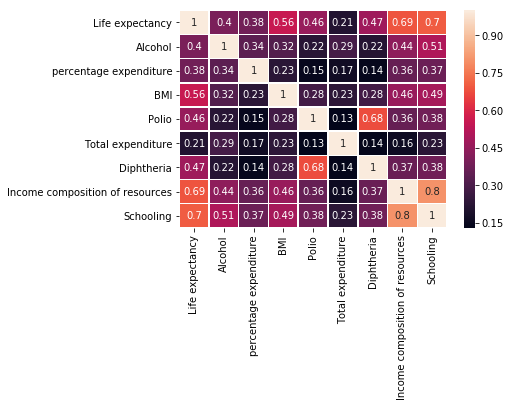

In [28]:
positive_df = df.loc[:, positives]
negative_df = df.loc[:, negatives]

sns.heatmap(positive_df.corr(), annot=True, linewidth=0.5)
plt.show()

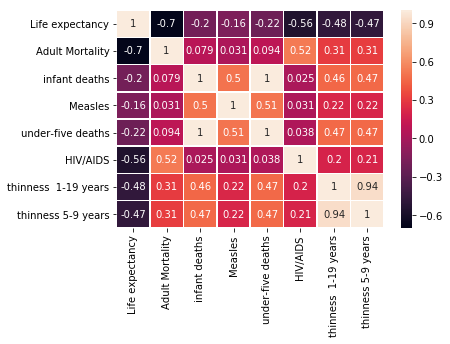

In [29]:
sns.heatmap(negative_df.corr(), annot=True, linewidth=0.5)
plt.show()

__In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.__

Based upon the heatmap and correlations between our features, I would select the following for our model.

In [30]:
features_target = ['BMI', 'Schooling', 'Diphtheria', 'Adult Mortality', 'HIV/AIDS', 'thinness  1-19 years', 'Life expectancy']

final_df = df.loc[:, features_target]

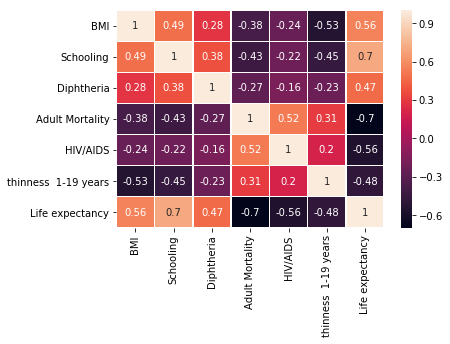

In [31]:
sns.heatmap(final_df.corr(), annot=True, linewidth=0.5)
plt.show()

__Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.__

To predict life expectancy in different countries, I chose a mix of features that would improve life expectancy and those that would not. Let's take a look at examples of both:

#### Features that improve life expectancy

We found features that indicated overall country well-being (such as amount of schooling), factors that represent a baseline level of healthcare (such as a percent of population vaccinated for column illnesses).

Let's see how these relate to life expectancy:

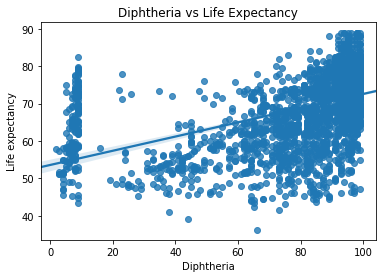

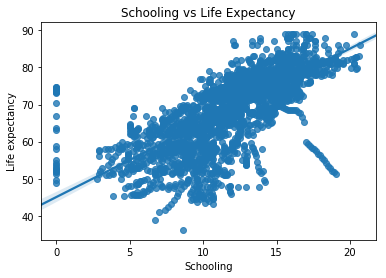

In [32]:
sns.regplot(x='Diphtheria', y='Life expectancy', data=final_df)
plt.title('Diphtheria vs Life Expectancy')
plt.show()

sns.regplot(x='Schooling', y='Life expectancy', data=final_df)
plt.title('Schooling vs Life Expectancy')
plt.show()

Both factors have some factors with outliers, however the overall trend shows that increasing vaccinations and increasing the level of schooling could lead to an increase in a countries' life expectancy.

What was interesting was factors such as an increase in Body-Mass Index was also correlated with an increase in life expectancy.

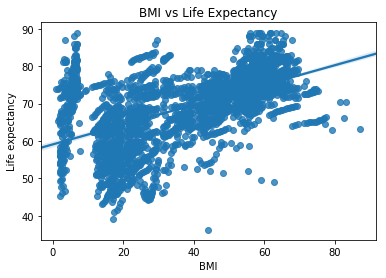

In [33]:
sns.regplot(x='BMI', y='Life expectancy', data=final_df)
plt.title('BMI vs Life Expectancy')
plt.show()

These also have some outliers, however the overall trend is positive. This seems counter-intuitive as a high BMI is thought of as unhealthy.

The reasoning behind this could be that countries with higher BMI's could have wealthier citizens that could be healthier (we'll find out if this is true in the section below).

Please note that GDP and population were not included in this analysis as the collected data were viewed as unreliable.

#### Features that decrease life expectancy

These were not as surprising. For example, a higher rate of HIV/Aids and a higher rate on thinness amongst 1-19 year olds will decrease overall life expectancy. See below:

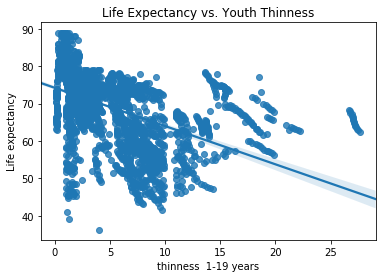

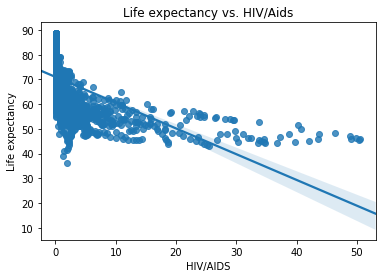

In [34]:
sns.regplot(x='thinness  1-19 years', y='Life expectancy', data=final_df)
plt.title('Life Expectancy vs. Youth Thinness')
plt.show()

sns.regplot(x='HIV/AIDS', y='Life expectancy', data=final_df)
plt.title('Life expectancy vs. HIV/Aids')
plt.show()

As both above show, increasing these features will decrease life expectancy.

__Conclusion:__
There are certain features that will affect life expectancy amongst a countries' population. It should be advised which factors have a greater influence as was discucssed above and use this information to help countries in their decisions.

### Let's try this same analysis, but without dropping columns from the beginning.

In [35]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [36]:
#remove whitespace from column names
df = df.rename(str.strip, axis='columns')

#get columns ready for interpolation
columns = df. columns.tolist()
columns.remove('Country')
columns.remove('Year')
columns.remove('Status')

In [37]:
#fill nas with interpolation
for column in columns:
    df[column] = df[column].interpolate()

df.isnull().sum() / df.isnull().count() * 100

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness  1-19 years               0.0
thinness 5-9 years                 0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

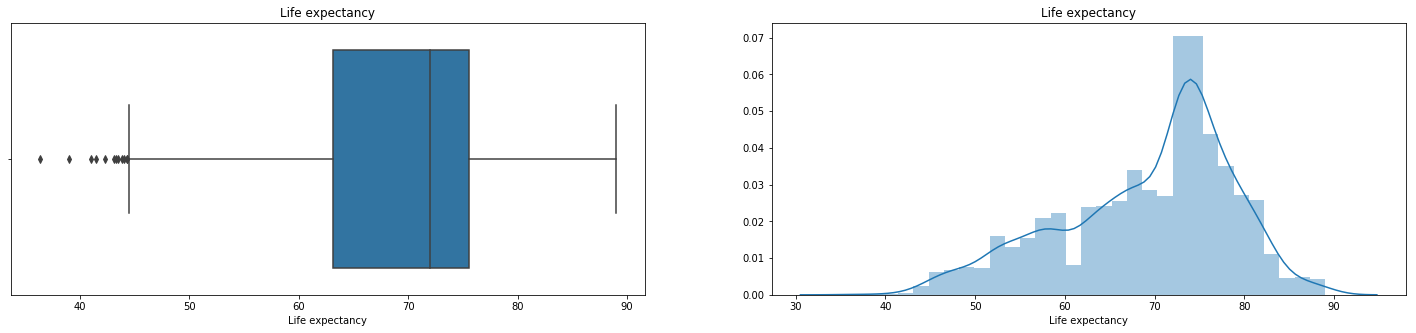

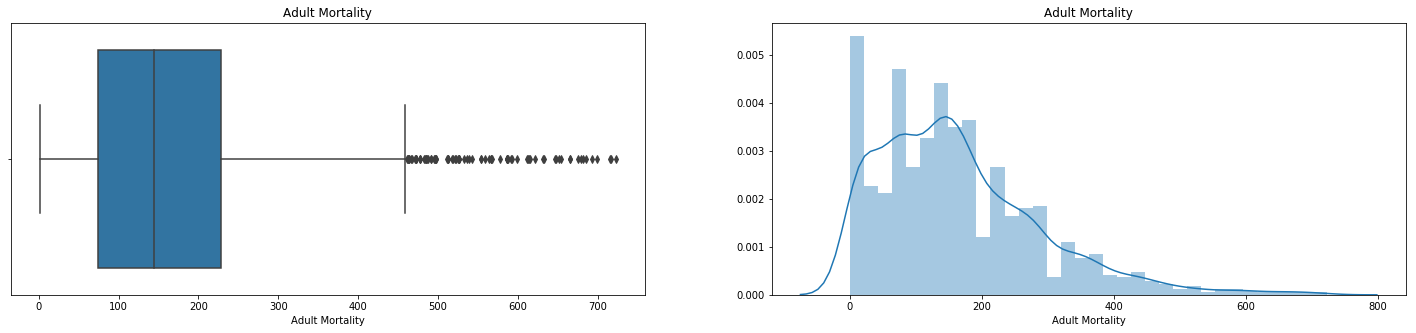

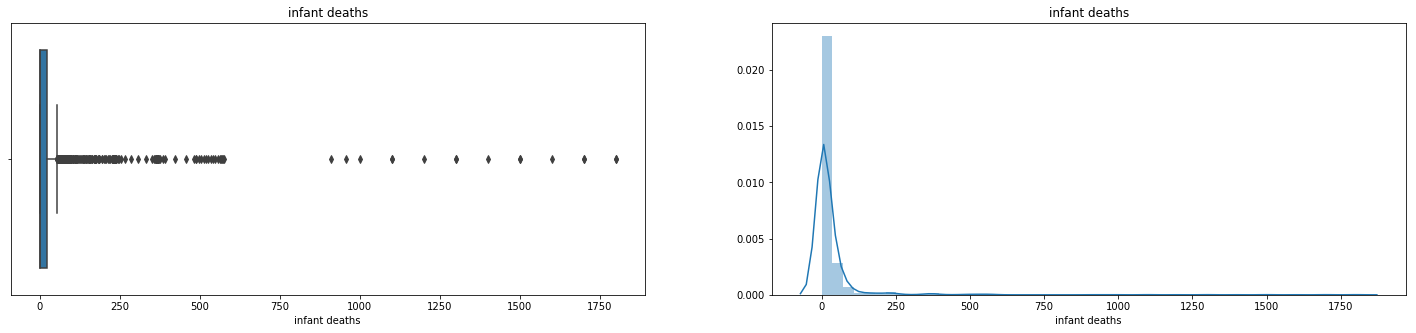

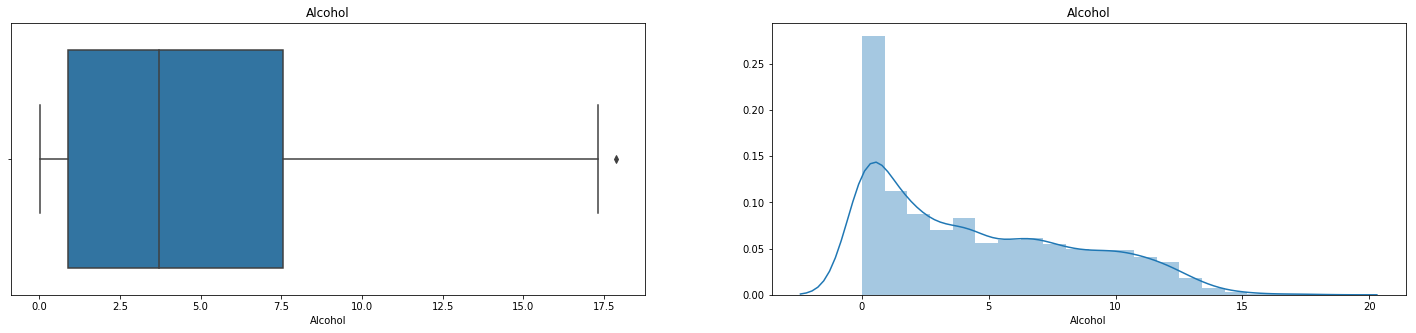

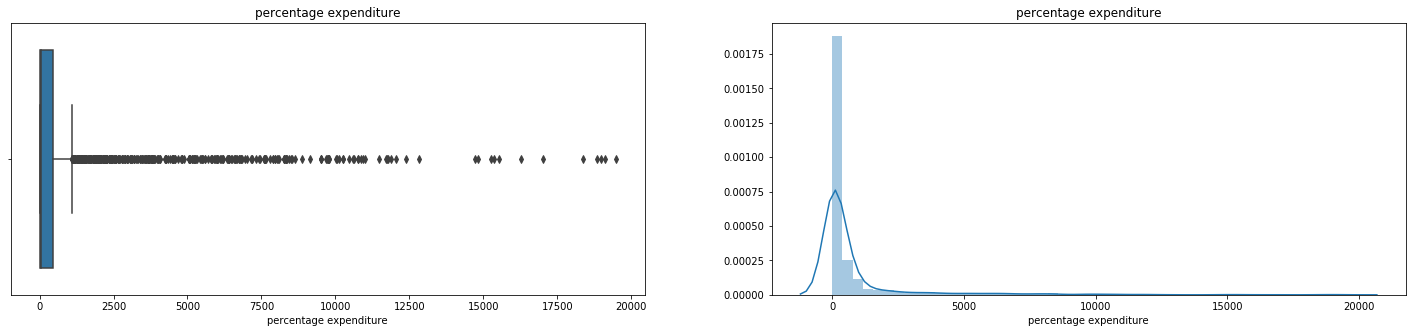

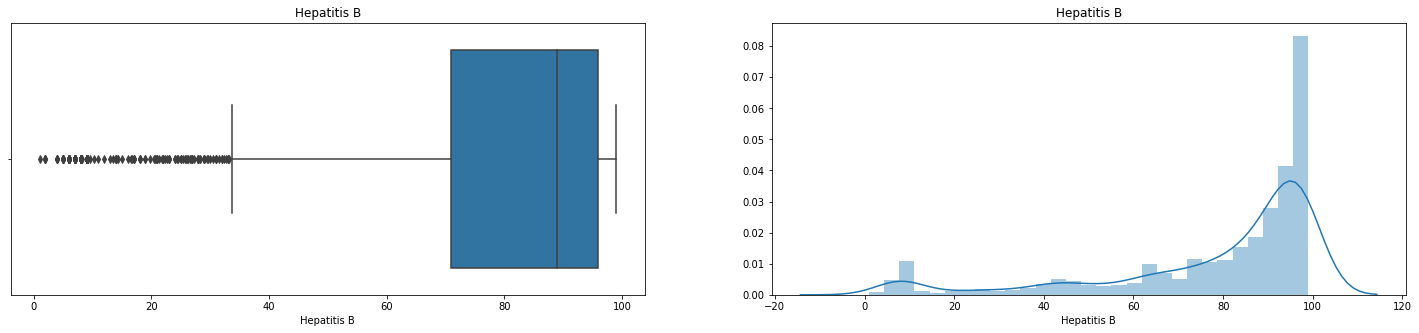

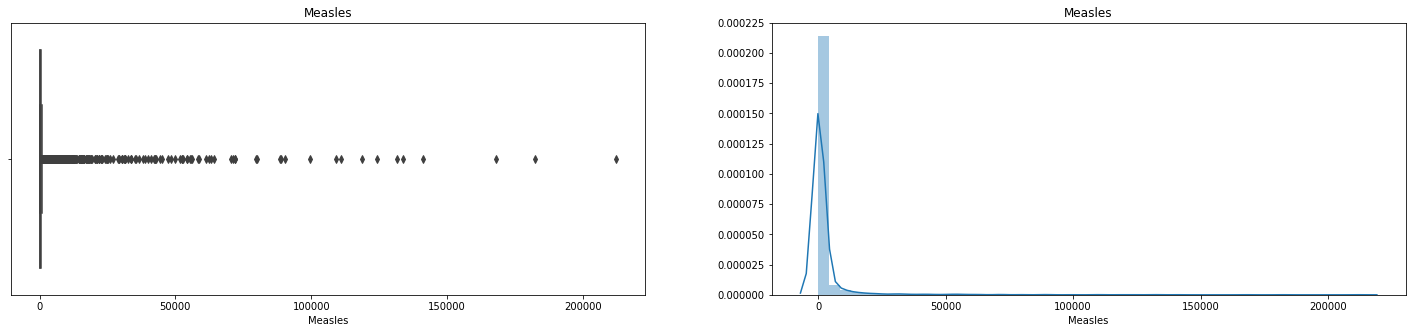

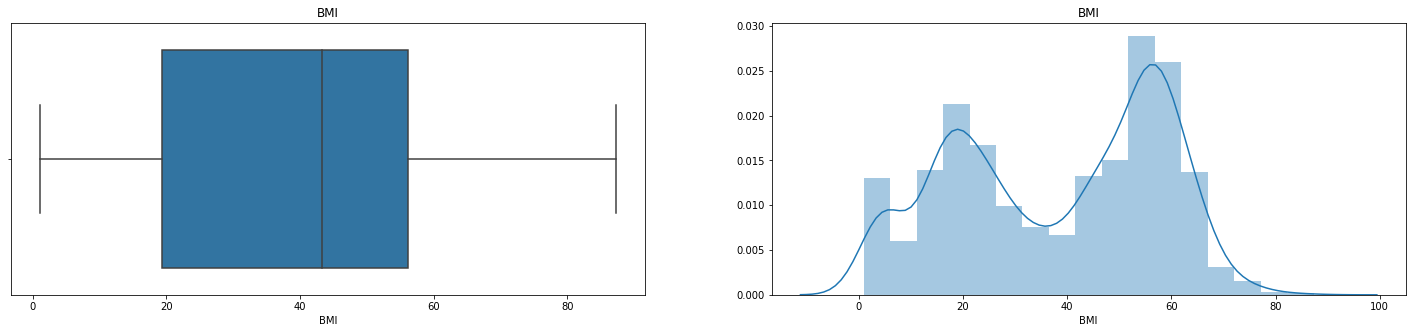

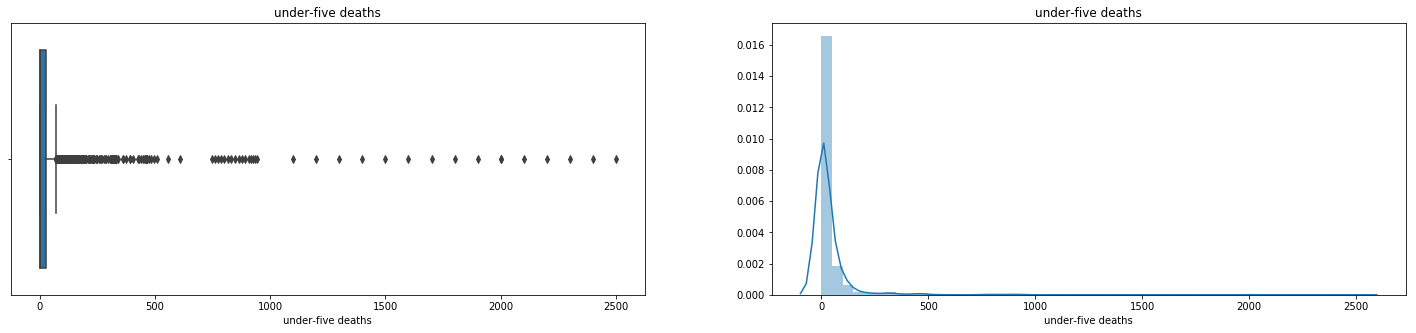

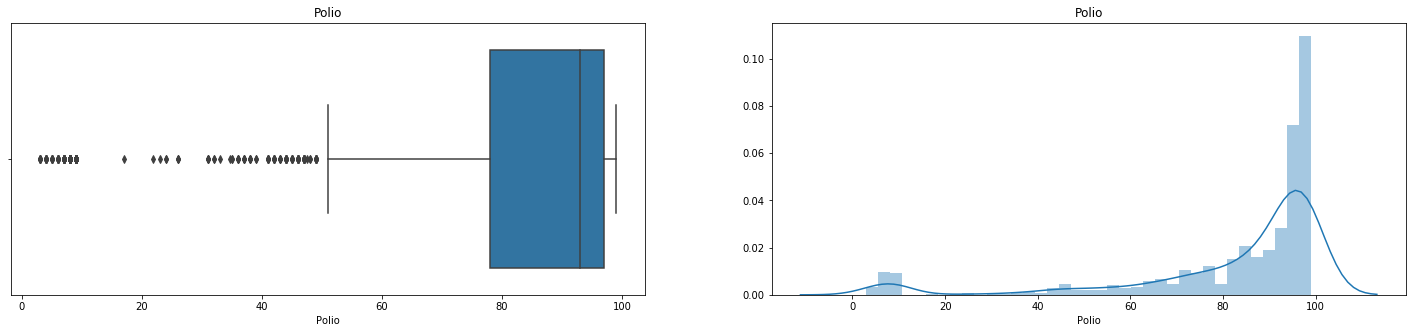

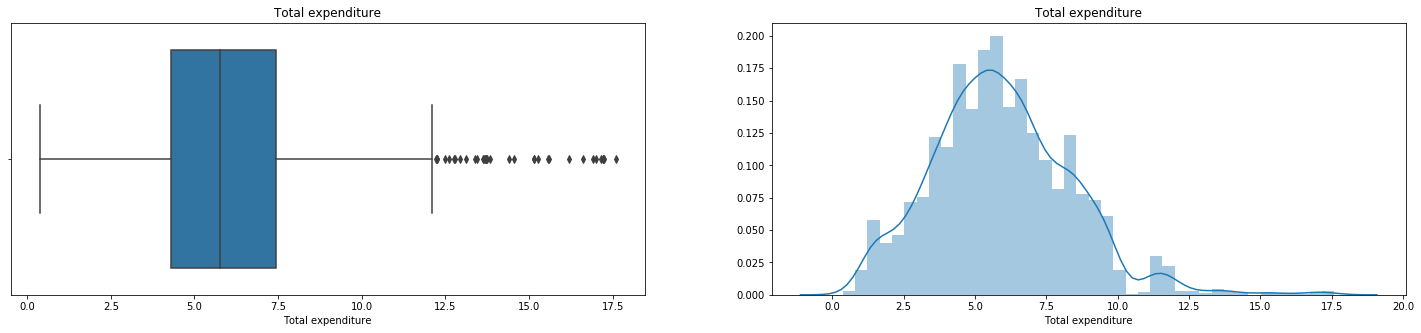

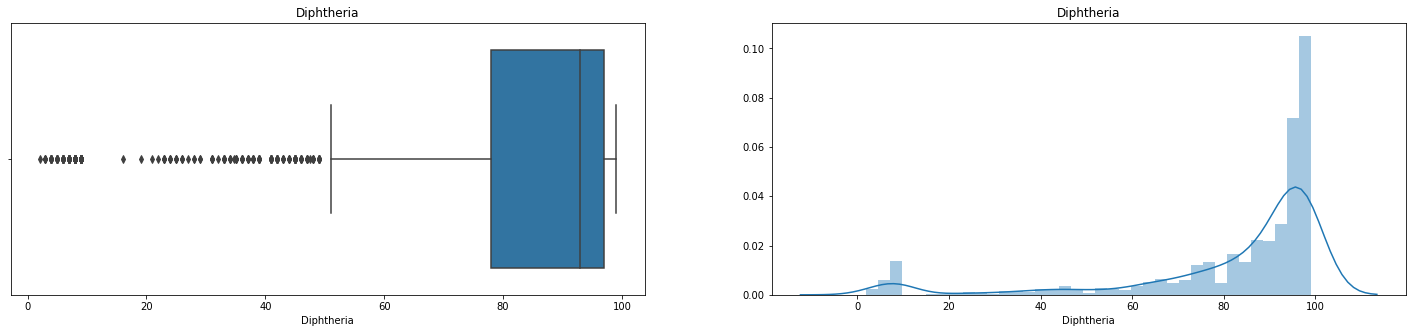

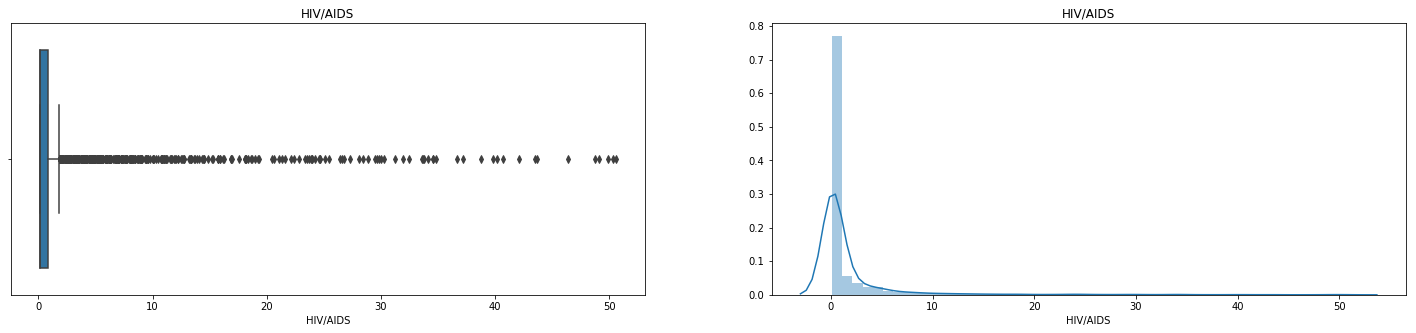

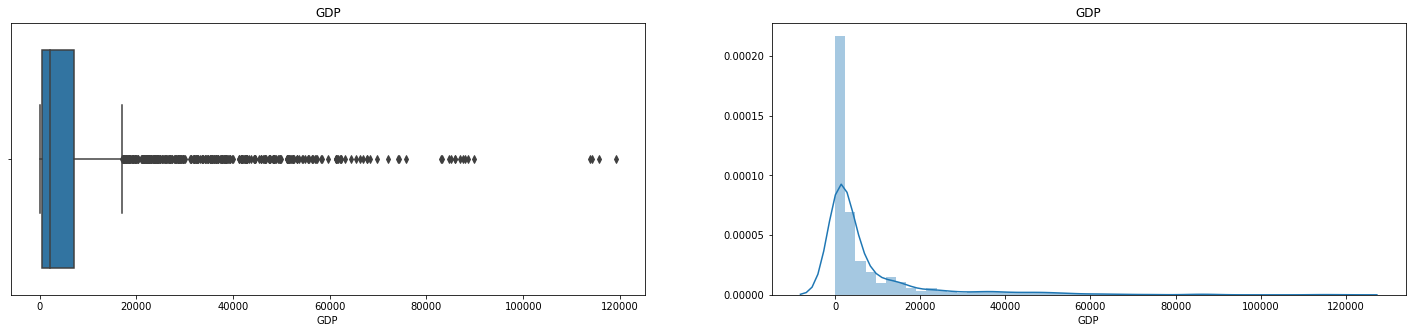

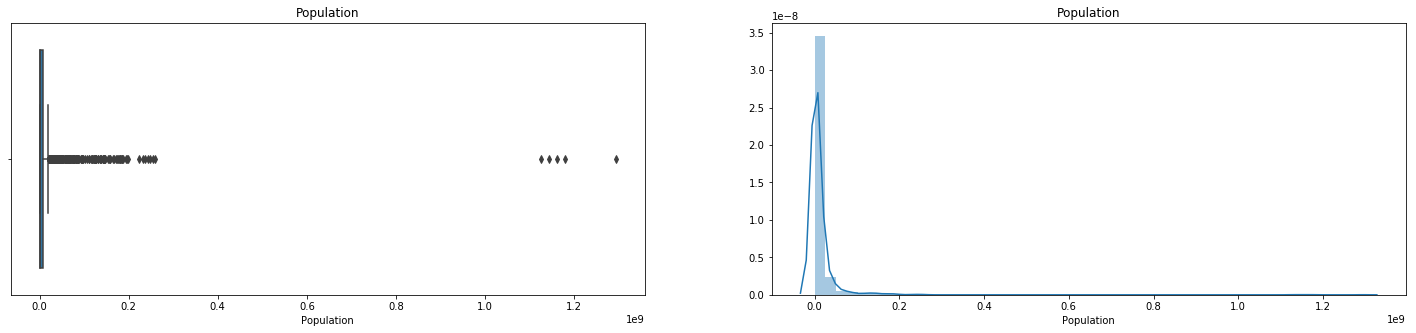

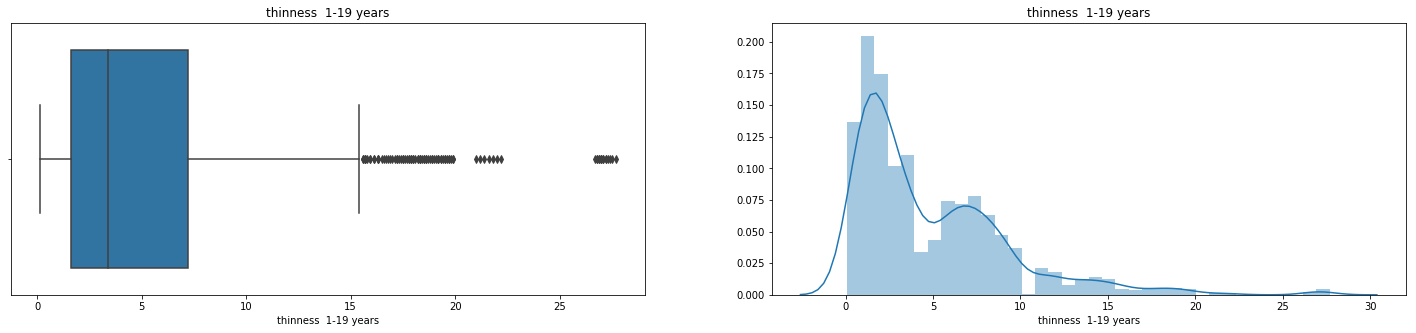

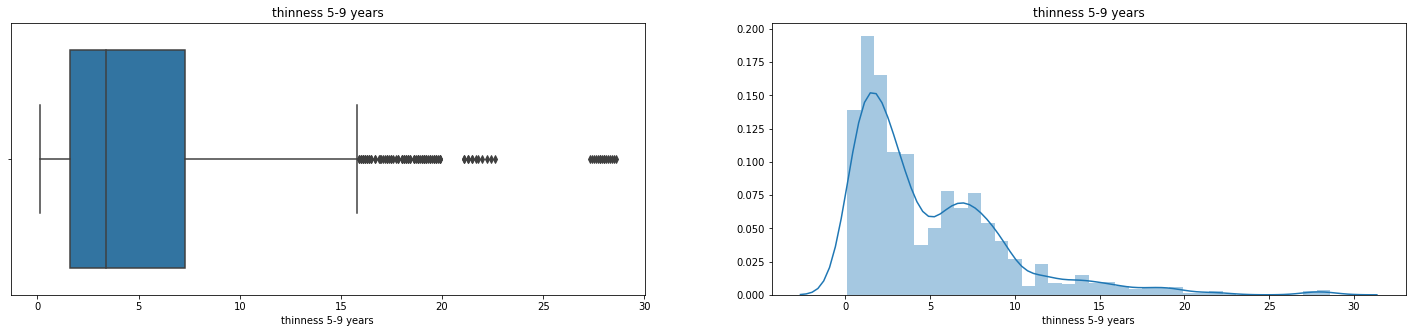

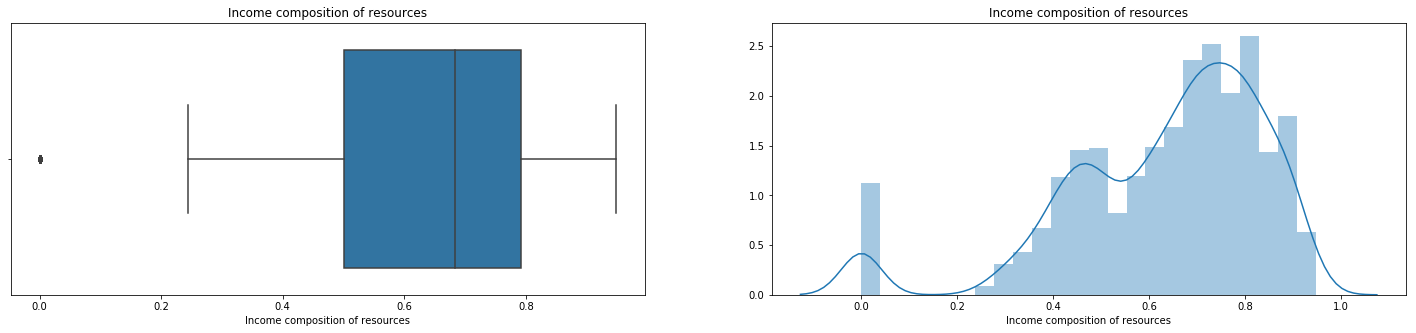

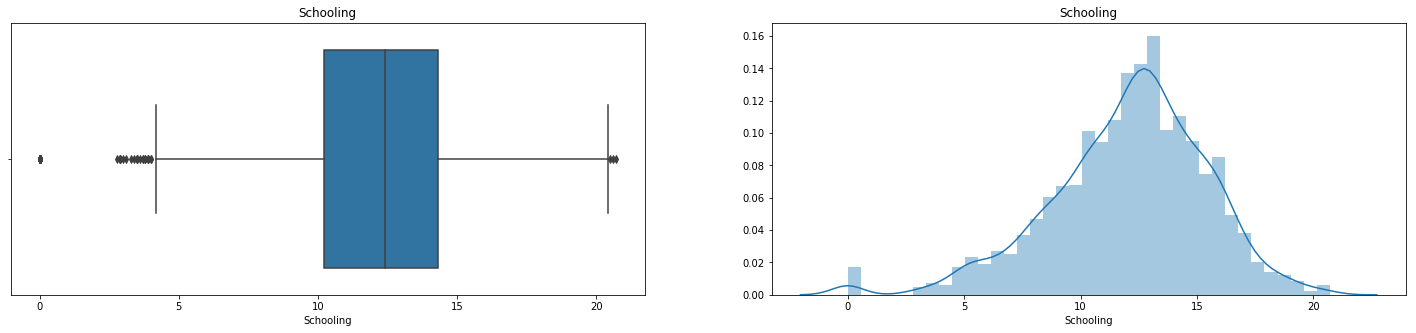

In [38]:
for column in columns:
    plt.figure(figsize=(25, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(df[column])
    plt.title('{}'.format(column))
    
    plt.subplot(1, 2, 2)
    sns.distplot(df[column])
    plt.title('{}'.format(column))
    plt.show()

The correlation coefficient between Life Expectancy and Life Expectancy is 1.0


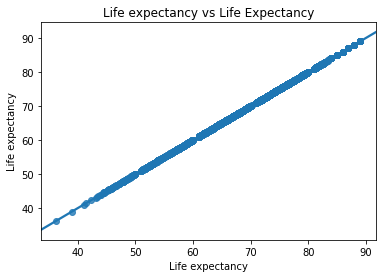

The correlation coefficient between Adult Mortality and Life Expectancy is -0.6957302834909396


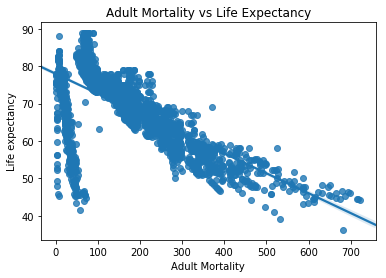

The correlation coefficient between Infant Deaths and Life Expectancy is -0.19619746554529316


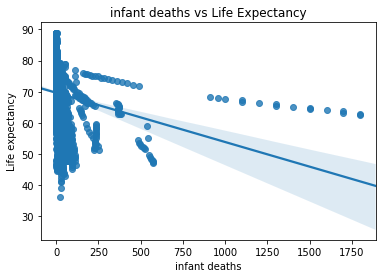

The correlation coefficient between Alcohol and Life Expectancy is 0.40006808360639456


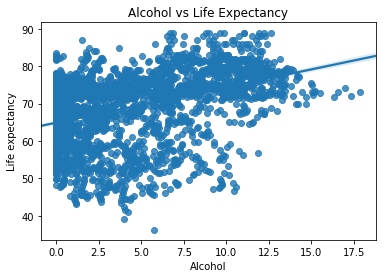

The correlation coefficient between Percentage Expenditure and Life Expectancy is 0.38206885112050176


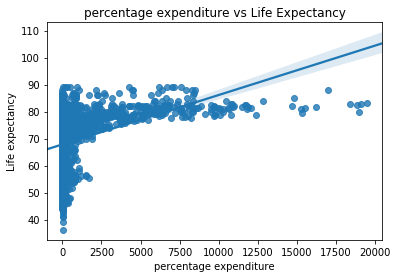

The correlation coefficient between Hepatitis B and Life Expectancy is 0.24741862423322658


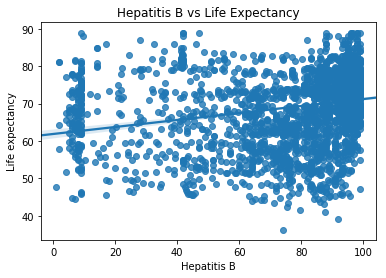

The correlation coefficient between Measles and Life Expectancy is -0.15729793807561737


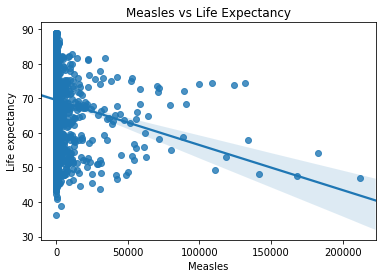

The correlation coefficient between Bmi and Life Expectancy is 0.556433178433153


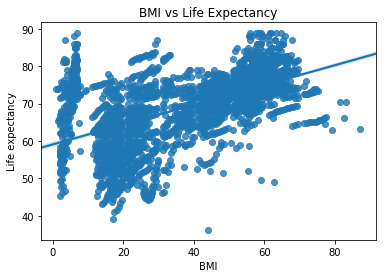

The correlation coefficient between Under-Five Deaths and Life Expectancy is -0.22215149275209978


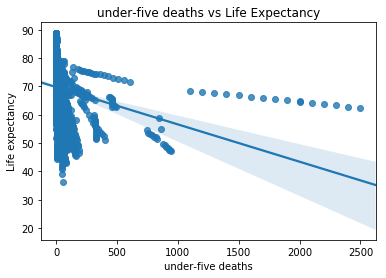

The correlation coefficient between Polio and Life Expectancy is 0.45986461720586697


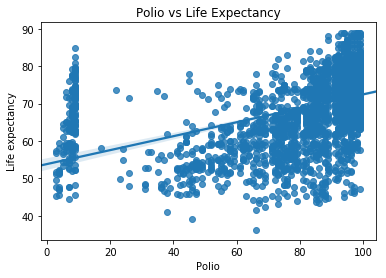

The correlation coefficient between Total Expenditure and Life Expectancy is 0.21084300448275425


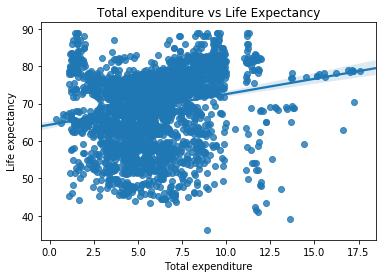

The correlation coefficient between Diphtheria and Life Expectancy is 0.4740844296049732


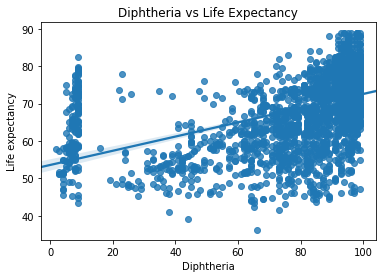

The correlation coefficient between Hiv/Aids and Life Expectancy is -0.5559287057539717


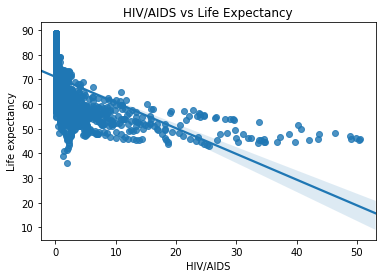

The correlation coefficient between Gdp and Life Expectancy is 0.4358543045894939


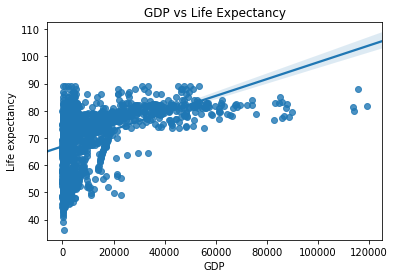

The correlation coefficient between Population and Life Expectancy is -0.007126382418253441


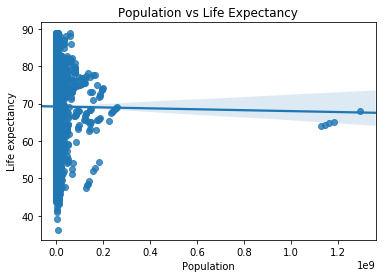

The correlation coefficient between Thinness  1-19 Years and Life Expectancy is -0.476808562984325


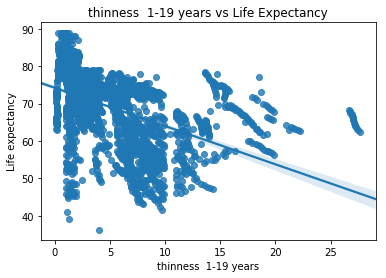

The correlation coefficient between Thinness 5-9 Years and Life Expectancy is -0.47248473590246587


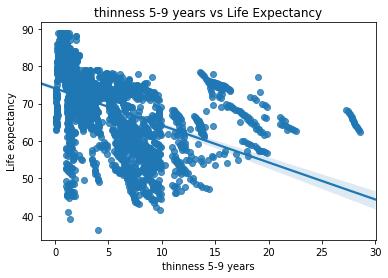

The correlation coefficient between Income Composition Of Resources and Life Expectancy is 0.6900712847842034


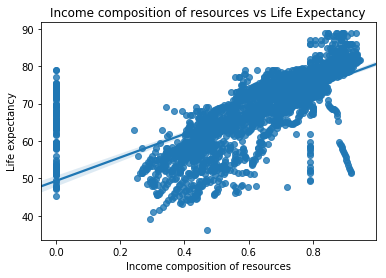

The correlation coefficient between Schooling and Life Expectancy is 0.7034093483533709


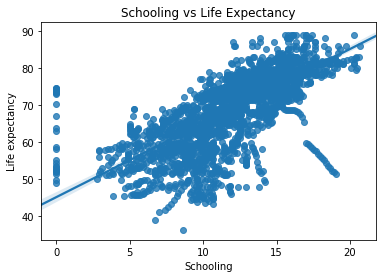

In [39]:
positives = []
negatives = ['Life expectancy']

for column in columns:
    #calculate the correlation coefficient
    corr, p_value = stats.pearsonr(target, df[column])
    
    #add to either negative or positive lists
    if (corr > 0):
        positives.append(column)
    else:
        negatives.append(column)
    
    #view our results
    print('The correlation coefficient between {} and Life Expectancy is {}'.format(column.title(), corr))
    sns.regplot(x=column, y='Life expectancy', data=df)
    plt.title('{} vs Life Expectancy'.format(column))
    plt.show()

In [40]:
positive_df = df.loc[:, positives]
negative_df = df.loc[:, negatives]

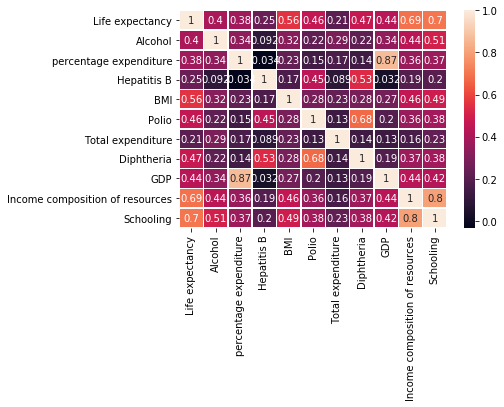

In [41]:
sns.heatmap(positive_df.corr(), annot=True, linewidth=0.5)
plt.show()

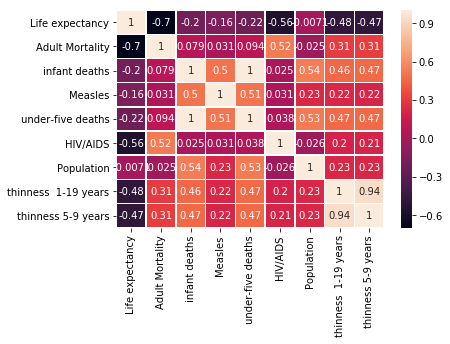

In [42]:
sns.heatmap(negative_df.corr(), annot=True, linewidth=0.5)
plt.show()

In [43]:
features = ['Life expectancy', 'Schooling', 'BMI', 'Diphtheria', 'GDP', 'Adult Mortality', 'thinness  1-19 years', 'HIV/AIDS']
final_df = df.loc[:, features]
final_df.head(15)

,Life expectancy,Schooling,BMI,Diphtheria,GDP,Adult Mortality,thinness 1-19 years,HIV/AIDS
0,65.0,10.1,19.1,65.0,584.259210,263.0,17.2,0.1
1,59.9,10.0,18.6,62.0,612.696514,271.0,17.5,0.1
2,59.9,9.9,18.1,64.0,631.744976,268.0,17.7,0.1
3,59.5,9.8,17.6,67.0,669.959000,272.0,17.9,0.1
4,59.2,9.5,17.2,68.0,63.537231,275.0,18.2,0.1
5,58.8,9.2,16.7,66.0,553.328940,279.0,18.4,0.1
6,58.6,8.9,16.2,63.0,445.893298,281.0,18.6,0.1
7,58.1,8.7,15.7,64.0,373.361116,287.0,18.8,0.1
8,57.5,8.4,15.2,63.0,369.835796,295.0,19.0,0.1
9,57.3,8.1,14.7,58.0,272.563770,295.0,19.2,0.1


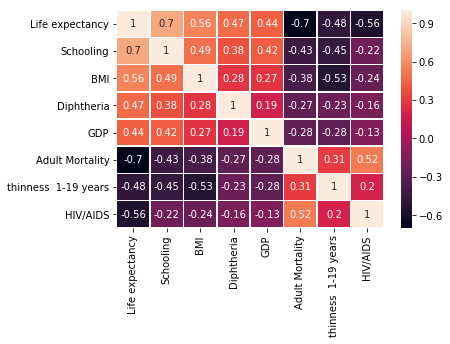

In [44]:
sns.heatmap(final_df.corr(), annot=True, linewidth=0.5)
plt.show()

So, it's nice that our feature selection choices didn't differ much.